In [47]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

from parser_fun import merge_hdfs_multi
from plot_functions import auto_plot_style
from plot_functions import color_sequence
import plot_functions as pf

import analysis_functions as af
import stats

#Can be removed later
import importlib
importlib.reload(af)
importlib.reload(stats)
#

<module 'stats' from '/Users/samuele/Documents/Postdoc/NEXT/ASpirit/src/stats.py'>

In [2]:
folderdata = ["/Users/samuele/Documents/Postdoc/NEXT/TrgEff/data/15502/"]

In [3]:
df = merge_hdfs_multi(folderdata)

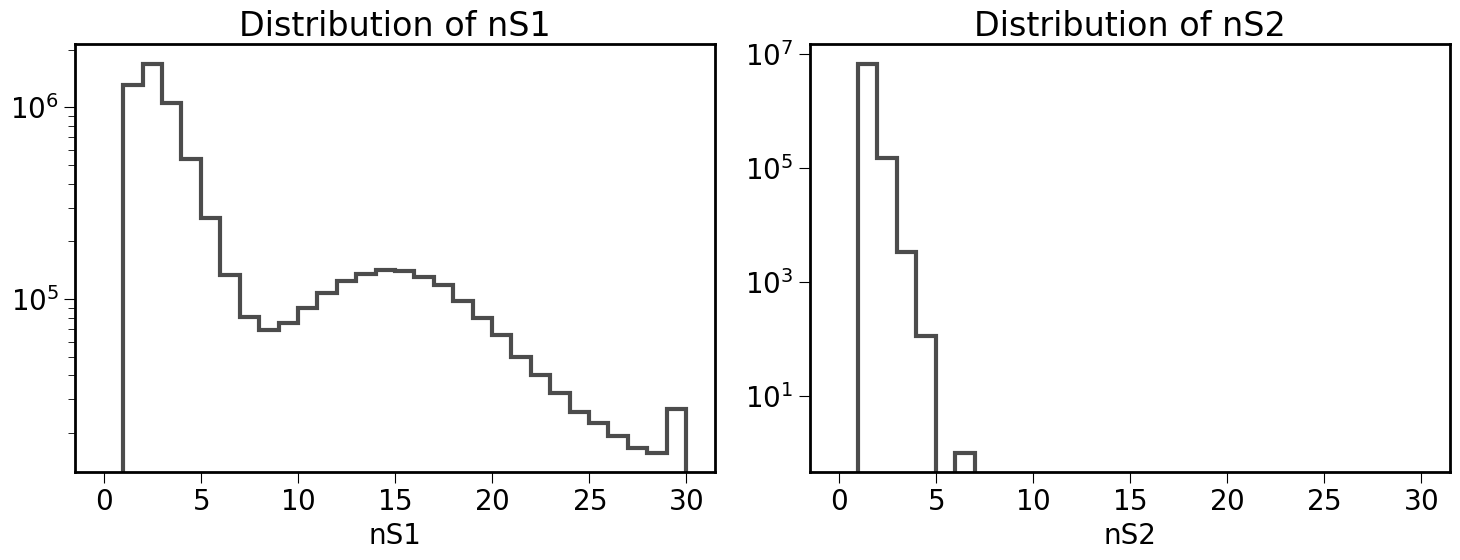

In [162]:
# Create a figure with three subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
auto_plot_style()

# Plot histogram of df_sel['s1w']
axes[0].hist(df[df['s2_peak']==0]['nS1'], bins=30, range=[0,30], histtype='step', color = color_sequence[0], alpha=0.7)
axes[0].set_xlabel('nS1')
axes[0].set_title('Distribution of nS1')
axes[0].set_yscale('log')

# Plot histogram of df_sel['s1e']
axes[1].hist(df[df['s2_peak']==0]['nS2'], bins=30, range = [0,30], histtype='step',color = color_sequence[0], alpha=0.7)
axes[1].set_xlabel('nS2')
axes[1].set_yscale('log')
axes[1].set_title('Distribution of nS2')

# Adjust layout for better spacing
plt.tight_layout()

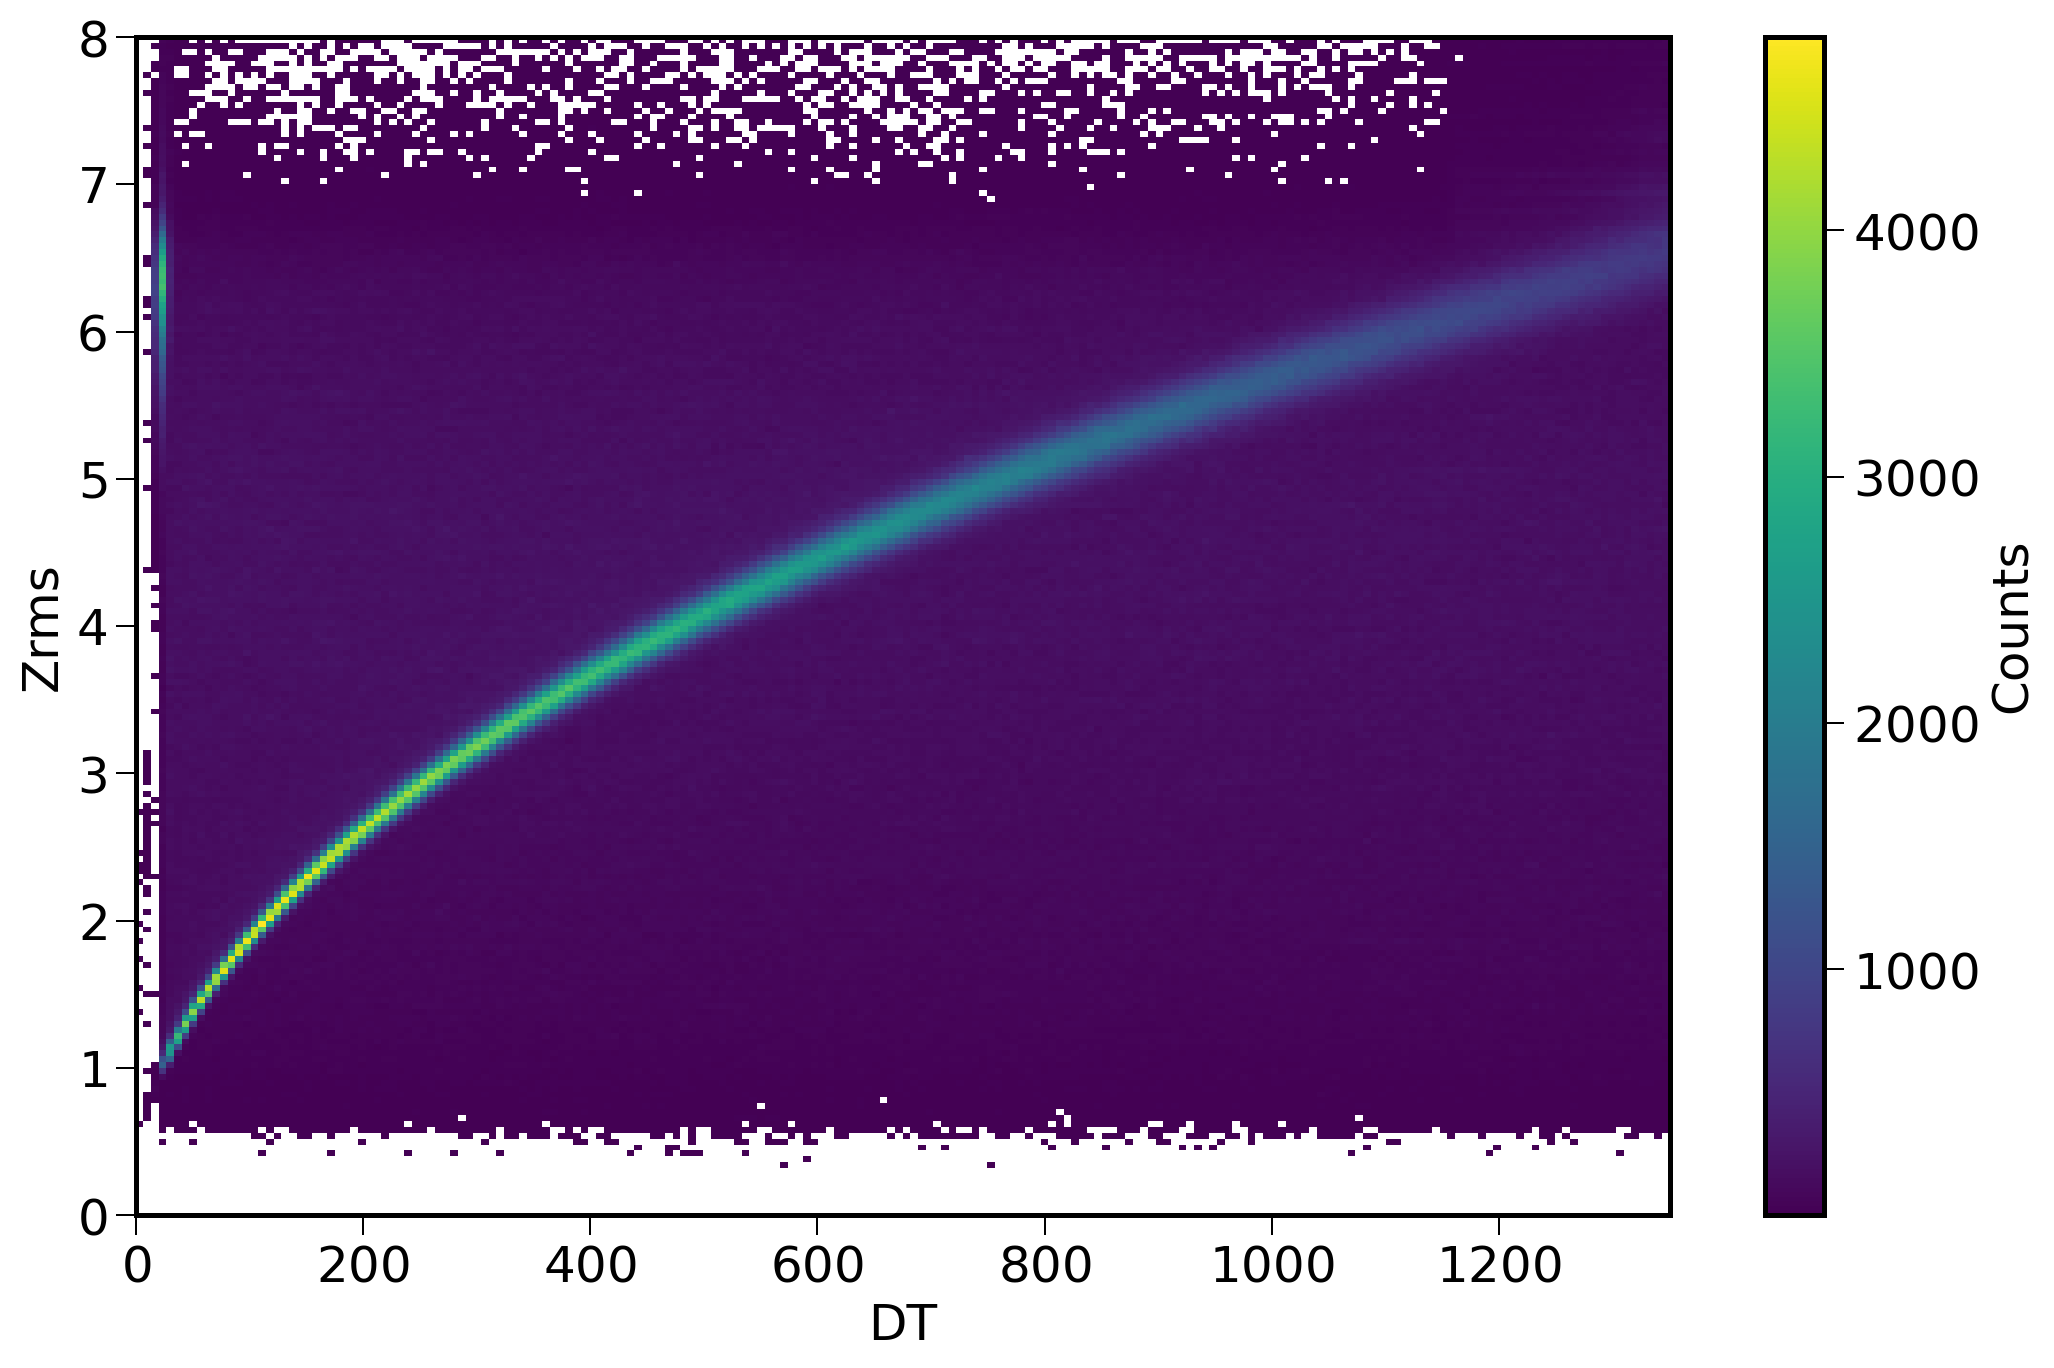

In [5]:
# Compute the 2D histogram data without plotting
counts, xedges, yedges = np.histogram2d(df['DT'], df['Zrms'], bins=200, range = ([0,1350],[0,8]))

# Mask bins with counts ≤ 1
counts[counts <= 1] = np.nan  # Convert low-count bins to NaN (displayed as white)

# Create the 2D histogram plot with masked data
plt.figure(figsize=(12, 8),dpi=180)

plt.pcolormesh(xedges, yedges, counts.T, cmap='viridis')
# Add labels and title
plt.xlabel('DT')
plt.ylabel('Zrms')

# Add colorbar to indicate counts
plt.colorbar(label='Counts')
plt.tight_layout()
plt.show()


### Diffusion band selection

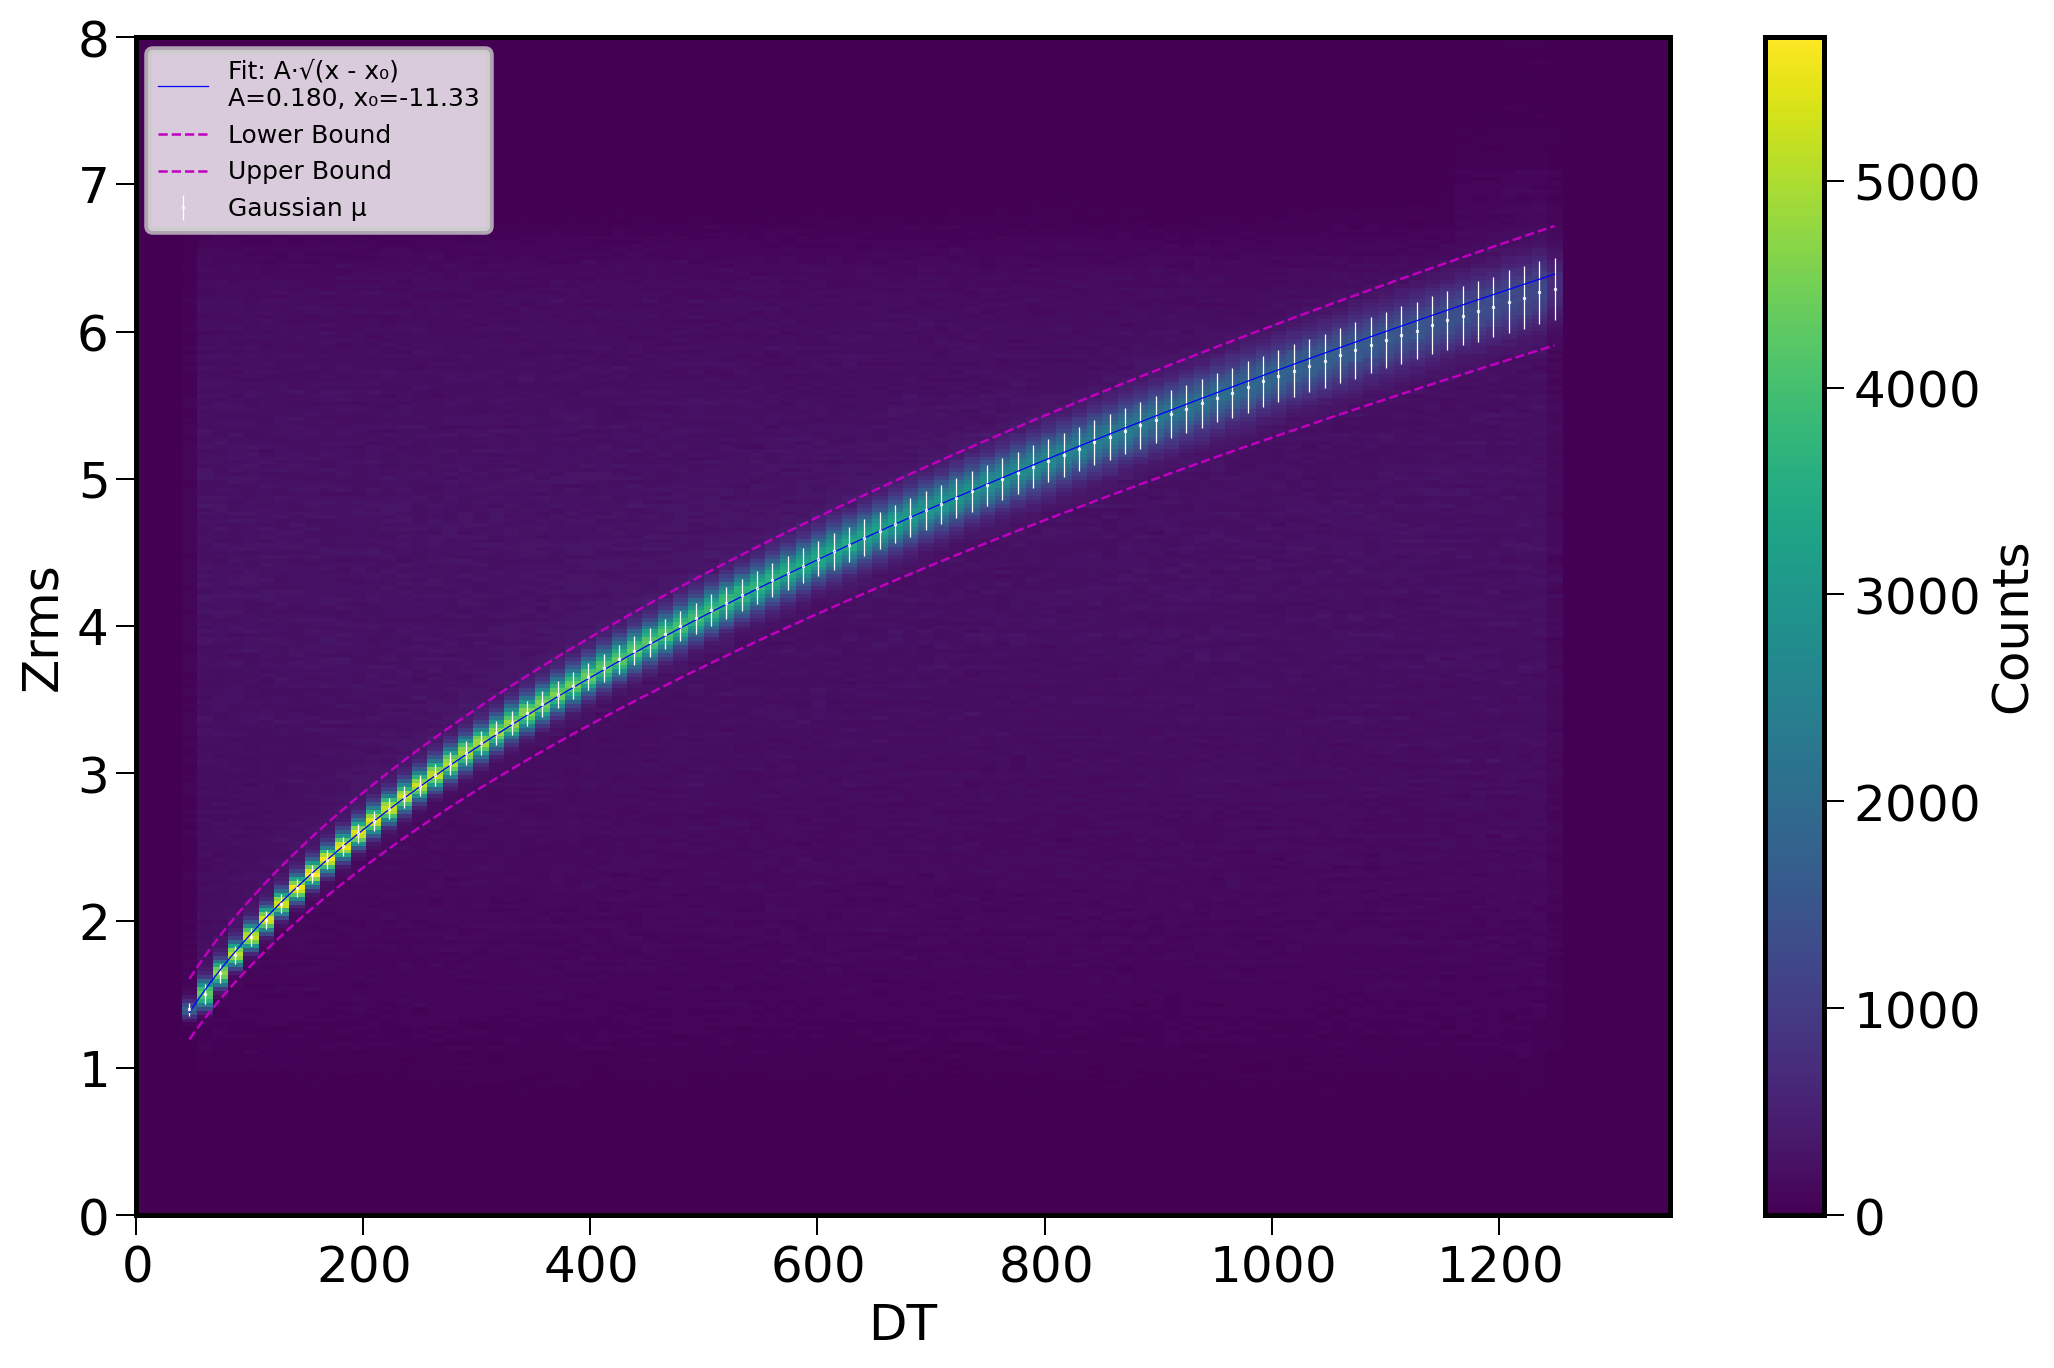

In [180]:
def sqrt_function(x, A, x0):
    return A * np.sqrt(x - x0)

counts, xedges, yedges = np.histogram2d(
    df[(df['DT'] > 50) & (df['DT'] < 1250)]['DT'],
    df[(df['DT'] > 50) & (df['DT'] < 1250)]['Zrms'],
    bins=(100, 300), range=([0, 1350], [0, 8])
)

dt_centers, mean_vals, mean_errs, sigma, sigma_errs = af.gaussian_profiler_y(counts, xedges, yedges)

popt_sqrt, pcov_sqrt = curve_fit(sqrt_function, dt_centers, mean_vals, sigma=mean_errs, p0=[0.1,-0.1])

plt.figure(figsize=(12, 8), dpi=180)

# Plot 2D histogram
plt.imshow(
    counts.T,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect='auto',
    origin='lower',
    cmap='viridis'
)

# Overlay mean values and fit
plt.errorbar(dt_centers, mean_vals, yerr=sigma, fmt='.', markersize=.7, linewidth=.5, color='white', label='Gaussian μ')
xfit = np.linspace(min(dt_centers), max(dt_centers), 500)

plt.plot(xfit, sqrt_function(xfit, *popt_sqrt), 'b-', linewidth=.5, label=f'Fit: A·√(x - x₀)\nA={popt_sqrt[0]:.3f}, x₀={popt_sqrt[1]:.2f}')

y_center = sqrt_function(xfit, *popt_sqrt)
lower_bound = y_center - 0.1 - 0.06 * y_center
upper_bound = y_center + 0.2 + 0.02 * y_center

plt.plot(xfit, lower_bound, 'm--', linewidth=1., label='Lower Bound')
plt.plot(xfit, upper_bound, 'm--', linewidth=1., label='Upper Bound')

# Labels and aesthetics
plt.xlabel('DT')
plt.ylabel('Zrms')
plt.colorbar(label='Counts')
plt.grid(False)
plt.legend(fontsize=10)
plt.tight_layout()

In [7]:
df_sel_diff = df[ (df['Zrms'] > sqrt_function(df['DT'],*popt_sqrt)-0.1-0.06*sqrt_function(df['DT'],*popt_sqrt) ) 
                    & (df['Zrms'] < sqrt_function(df['DT'],*popt_sqrt)+0.2+0.02*sqrt_function(df['DT'],*popt_sqrt) )  ]

print(f"NEvent filtered road : {len(np.unique(df_sel_diff['event']))}")
print(f"eff:{(len(np.unique(df_sel_diff['event']))/len(np.unique(df['event'])))*100:.2f}%")

/Users/samuele/Software/miniforge3/envs/IC/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


NEvent filtered road : 2464759
eff:86.70%


### 1S1 & 1S2 left selection

In [8]:
df_single_s1_peak = df_sel_diff.groupby('time').filter(lambda x: (x['s1_peak'].count() == 1) & (x['s2_peak'].count() == 1))

print(f"NEvent filtered road : {len(np.unique(df_single_s1_peak['event']))}")
print(f"eff:{(len(np.unique(df_single_s1_peak['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 2049207
eff:72.08%


### Geometric Selection

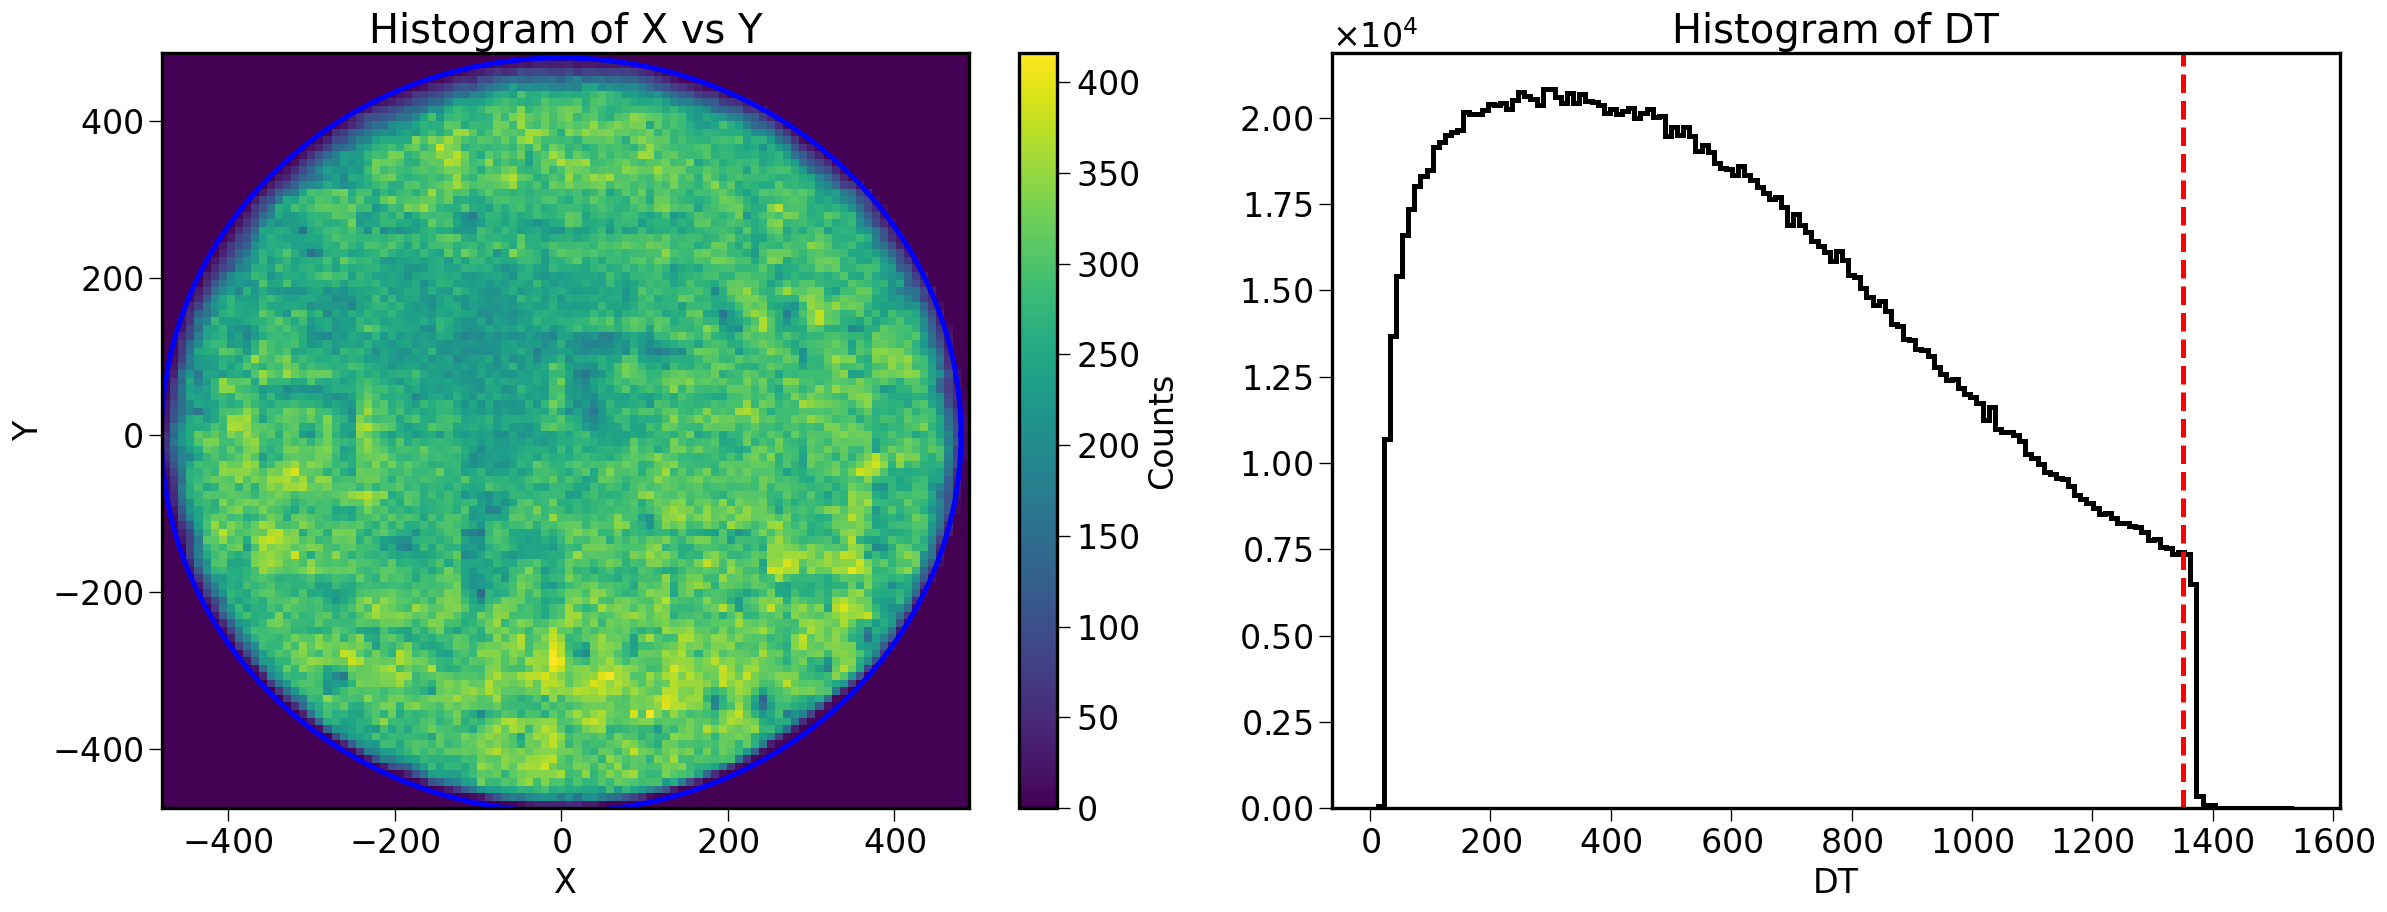

In [181]:
#GeoSel
rad = 480
z = 1350

# Create a figure with two subplots in a row
fig, axes = plt.subplots(1, 2, figsize=(20, 8), dpi=120)

# Plot histogram of X vs Y
axes[0].hist2d(df_single_s1_peak['X'], df_single_s1_peak['Y'], bins=100, cmap='viridis')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
axes[0].set_title('Histogram of X vs Y')
plt.colorbar(axes[0].collections[0], ax=axes[0], label='Counts')

# Generate points for the circumference
theta = np.linspace(0, 2 * np.pi, 300)
x_circle = 0 + rad * np.cos(theta)
y_circle = 0 + rad * np.sin(theta)
# Plot the circumference
axes[0].plot(x_circle, y_circle, color='blue')

# Plot histogram of X vs DT
axes[1].hist(df_single_s1_peak['DT'], bins=150,histtype='step')
axes[1].set_xlabel('DT')
axes[1].set_title('Histogram of DT')
#axes[1].set_ylim([0,4000])
# Plot the vertical line at x = 1000
axes[1].axvline(x=z, color='red', linestyle='--', label='Vertical Line (x=1000)')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [164]:
df_single_s1_peak_geo = df_single_s1_peak[ (df_single_s1_peak['DT']<1350) & (np.sqrt(df_single_s1_peak['X']**2 + df_single_s1_peak['Y']**2)<480 )   ]

print(f"NEvent filtered road : {len(np.unique(df_single_s1_peak['event']))}")
print(f"eff:{(len(np.unique(df_single_s1_peak_geo['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 2049207
eff:71.49%


### Look at the data 

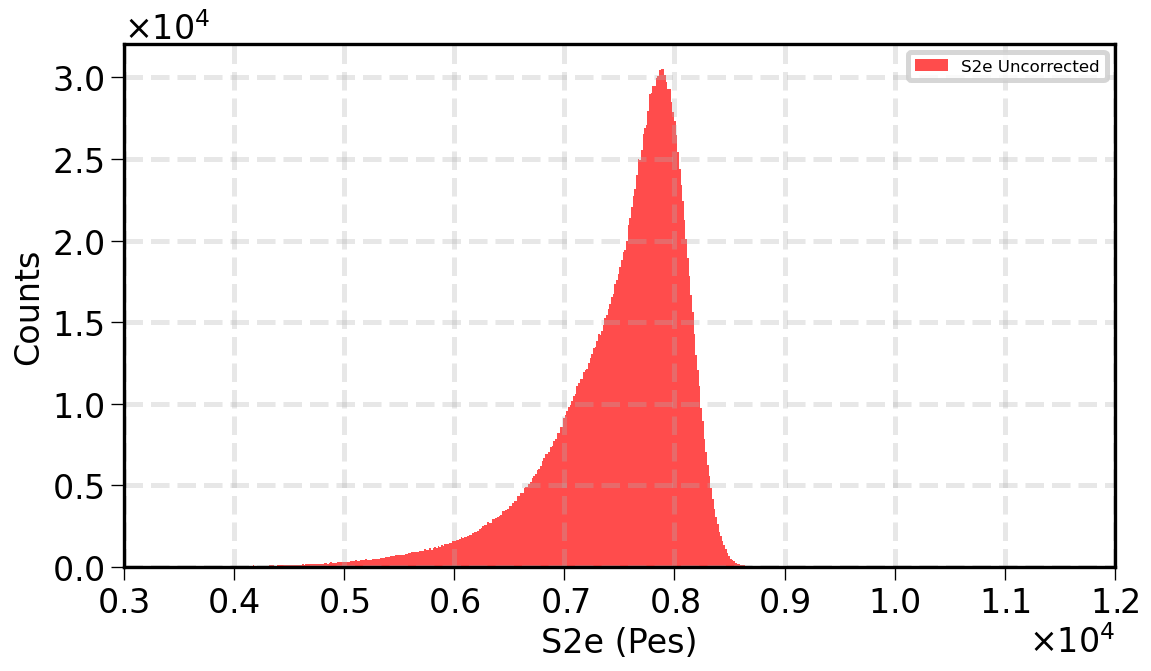

In [165]:
# Plot the histogram of S2e
plt.figure(figsize=(10, 6),dpi=120)
counts, bins, patches = plt.hist(df_single_s1_peak_geo['S2e'], bins=800, range=[0, 12000], 
                                color='red', alpha=0.7, label='S2e Uncorrected')

plt.xlabel('S2e (Pes)')
plt.ylabel('Counts')
plt.legend()
plt.xlim([3000,12000])

# Show the plot
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(fontsize=10)
plt.show()

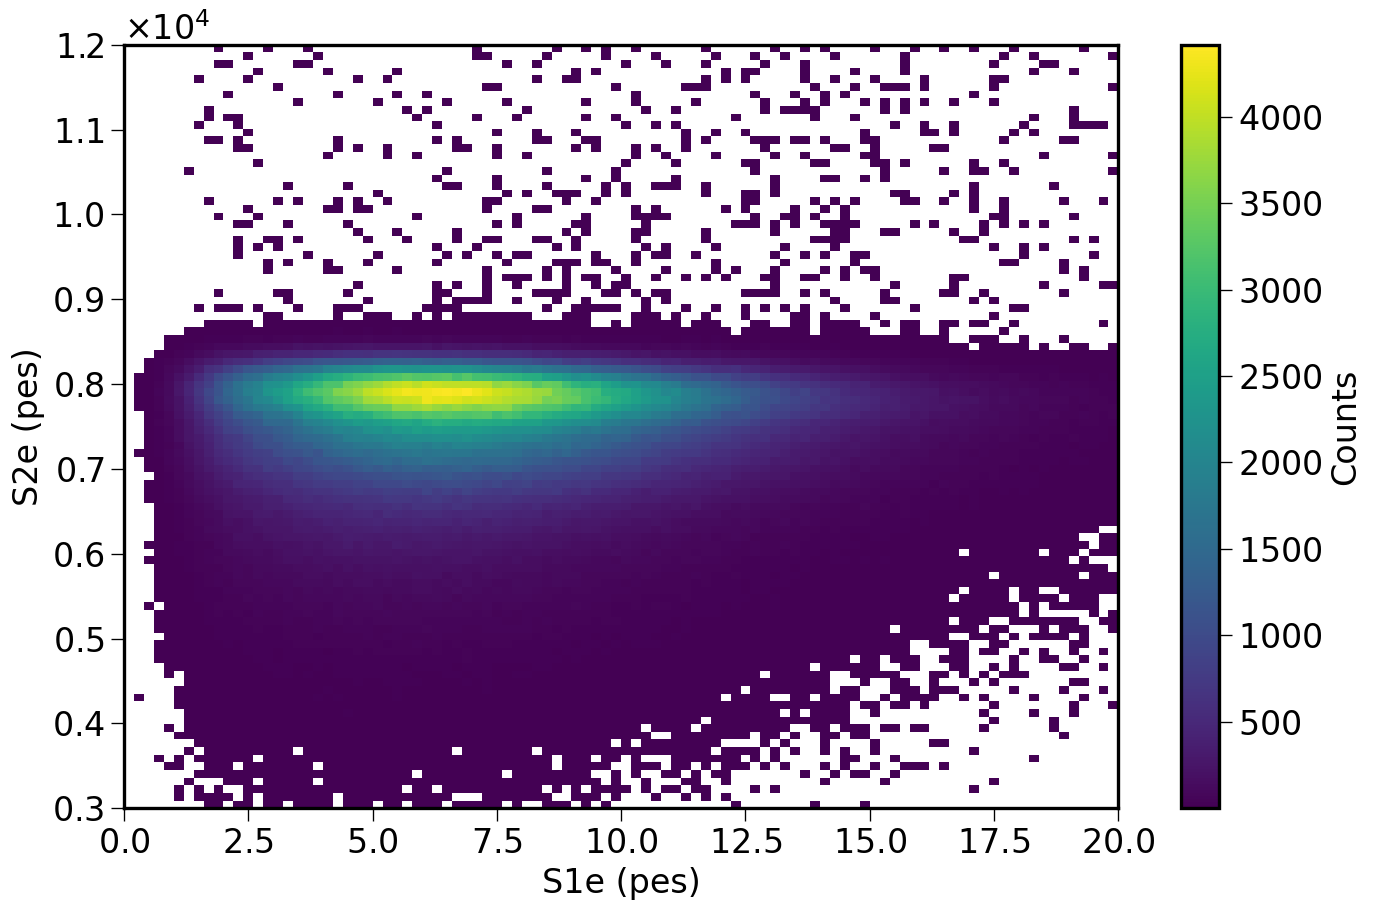

In [166]:
plt.figure(figsize=(12, 8), dpi=120)

counts, xedges, yedges = np.histogram2d(
    df_single_s1_peak_geo['S1e'],
    df_single_s1_peak_geo['S2e'],
    bins=100,
    range=[(0, 20), (3000, 12000)]
)

# Mask bins with counts < 1
counts_masked = np.where(counts < 1, np.nan, counts)

# Plot with pcolormesh
X, Y = np.meshgrid(xedges, yedges)
plt.pcolormesh(X, Y, counts_masked.T, cmap='viridis', shading='auto')  # transpose counts to align axes

plt.colorbar(label='Counts')
plt.xlabel('S1e (pes)')
plt.ylabel('S2e (pes)')
plt.tight_layout()
plt.show()

/var/folders/pd/hx80lcqj1szc4vdz3mbmmv680000gn/T/ipykernel_56538/2560408748.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single_s1_peak_geo['R'] = np.sqrt(df_single_s1_peak_geo['X']**2 + df_single_s1_peak_geo['Y']**2)


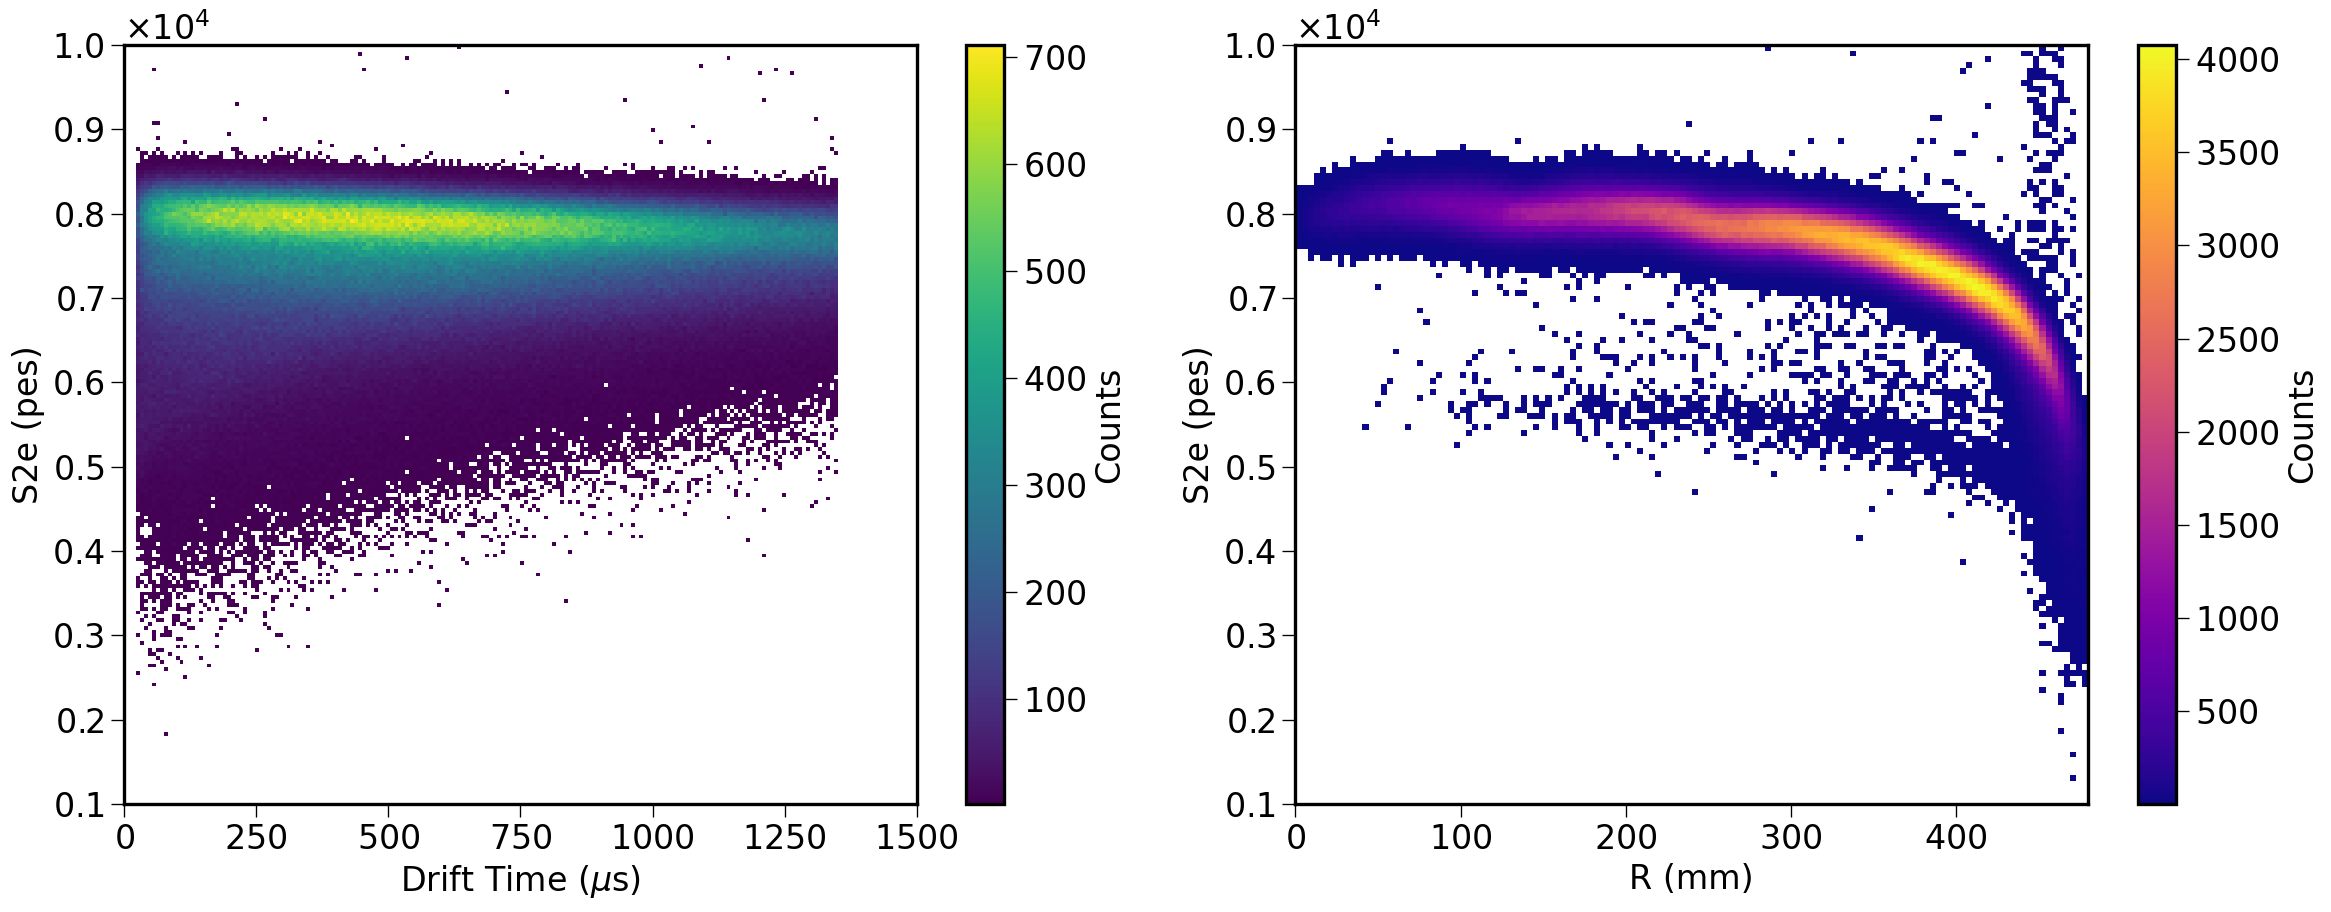

In [167]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8),dpi=120)

df_single_s1_peak_geo['R'] = np.sqrt(df_single_s1_peak_geo['X']**2 + df_single_s1_peak_geo['Y']**2)

# Plot 1: DT vs S2e
counts1, xedges1, yedges1 = np.histogram2d(df_single_s1_peak_geo['DT'], df_single_s1_peak_geo['S2e'], bins=200, range=([0, 1500], [1000, 10000]))
counts1[counts1 <= 1] = np.nan  # Mask bins with counts ≤ 1

axes[0].pcolormesh(xedges1, yedges1, counts1.T, cmap='viridis')
axes[0].set_xlabel('Drift Time ($\mu$s)')
axes[0].set_ylabel('S2e (pes)')
fig.colorbar(axes[0].collections[0], ax=axes[0], label='Counts')

# Compute histogram
counts2, xedges2, yedges2 = np.histogram2d(
    df_single_s1_peak_geo['R'],
    df_single_s1_peak_geo['S2e'],
    bins=130,
    range=([0, 480], [1000, 10000])
)

# Plot 2: sqrt(X^2 + Y^2) vs S2e
counts2, xedges2, yedges2 = np.histogram2d(df_single_s1_peak_geo['R'], df_single_s1_peak_geo['S2e'], bins=130, range=([0, 480], [1000, 10000]))
counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

axes[1].pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
axes[1].set_xlabel('R (mm)')
axes[1].set_ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

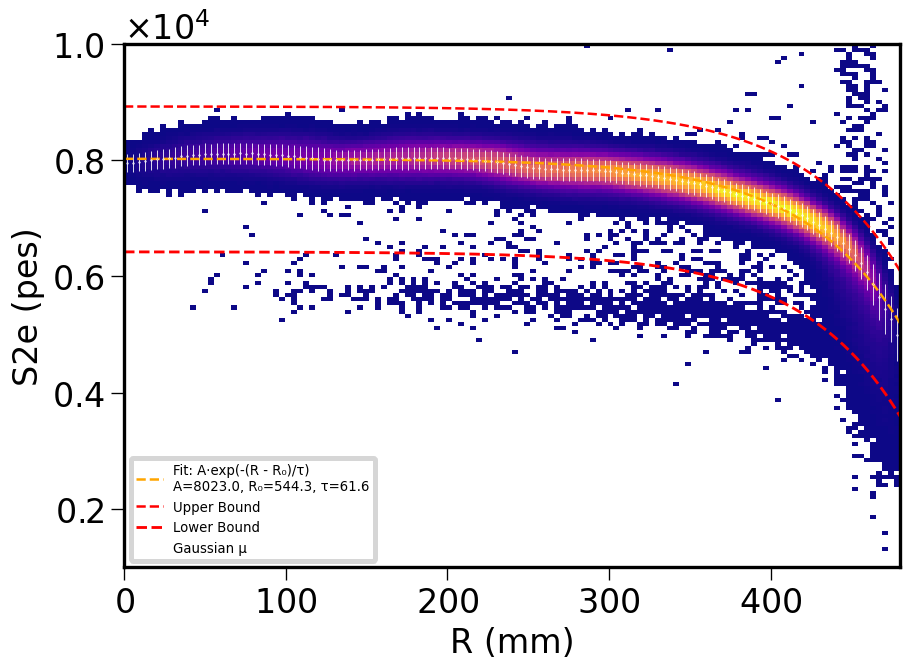

In [168]:
# Step 3: Fit with exponential model
def expo_model(R, A, R0, tau):
    return A *(1- np.exp((R - R0) / tau))

plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(df_single_s1_peak_geo['R'], df_single_s1_peak_geo['S2e'], bins=130, range=([0, 480], [1000, 10000]))
dt_centers, mean_vals, mean_errs, sigma, sigma_errs = af.gaussian_profiler_y(counts2, xedges2, yedges2)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

p0=[8000, 600, 100]
popt, _ = curve_fit(expo_model, dt_centers, mean_vals, p0=p0)

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
plt.xlabel('R (mm)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')
plt.errorbar(dt_centers, mean_vals, yerr=sigma, fmt='.', markersize=.7, linewidth=.5, color='white', label='Gaussian μ')

r_fit = np.linspace(0, 480, 500)
plt.plot(r_fit, expo_model(r_fit, *popt), color='orange', linestyle='--', linewidth=1.5, label=f'Fit: A·exp(-(R - R₀)/τ)\nA={popt[0]:.1f}, R₀={popt[1]:.1f}, τ={popt[2]:.1f}')
plt.plot(r_fit, expo_model(r_fit, *popt)+900, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bound')
plt.plot(r_fit, expo_model(r_fit, *popt)-1600, color='red', linestyle='--', linewidth=1.7, label=f'Lower Bound')

plt.legend(fontsize=8)
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [169]:
Krdf = df_single_s1_peak_geo[(df_single_s1_peak_geo['S2e'] >= expo_model(df_single_s1_peak_geo['R'], *popt) - 1600) & 
                             (df_single_s1_peak_geo['S2e'] <= expo_model(df_single_s1_peak_geo['R'], *popt) + 900)]

print(f"NEvent filtered road : {len(np.unique(Krdf['event']))}")
print(f"eff:{(len(np.unique(Krdf['event']))/len(np.unique(df['event'])))*100:.2f}%")

NEvent filtered road : 2023550
eff:71.18%


In [170]:
bins_xy = 100
z_bins = np.linspace(0,1350,30)
krmap = af.compute_map3D(Krdf, bins_xy = bins_xy, z_bins=z_bins)

In [171]:
max_index = np.unravel_index(np.argmax(krmap.hratio), krmap.hratio.shape)
hmap = np.divide(krmap.hratio, krmap.hratio[max_index], where=krmap.hcounts > 2)
krmap.hmap = hmap

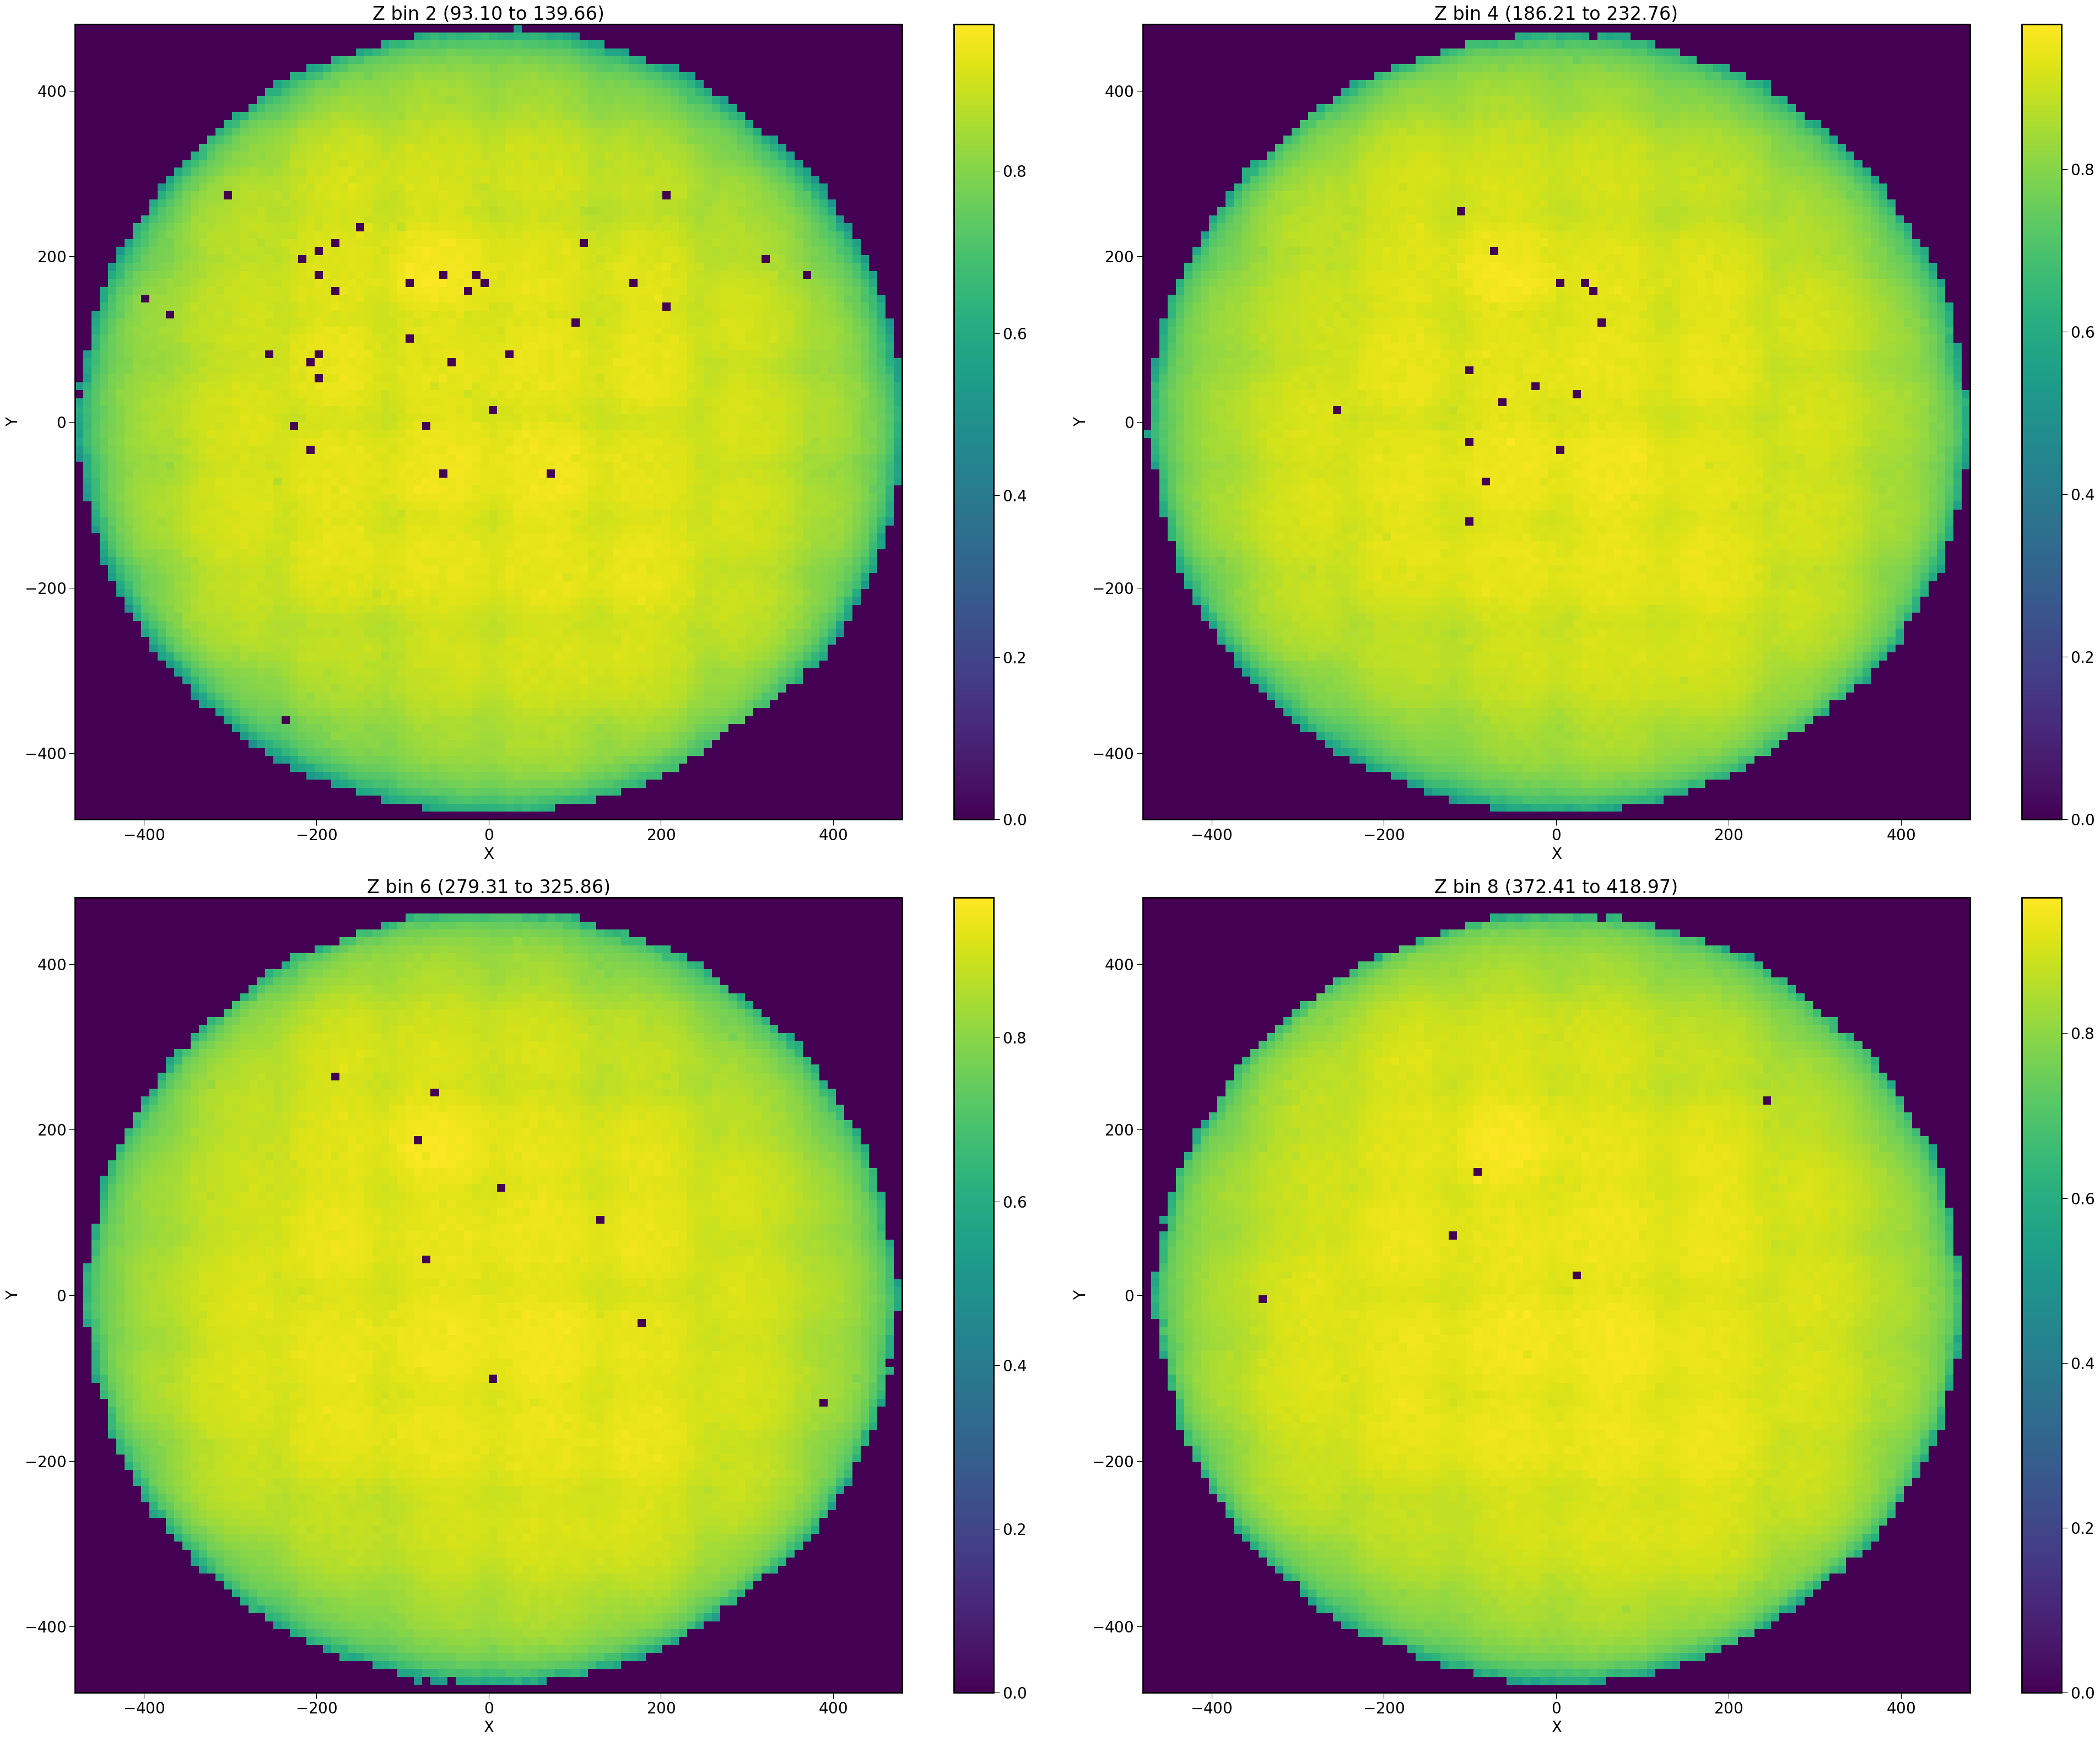

In [172]:
af.plot_3d_histogram_slices(krmap.hmap, krmap.xedges, krmap.yedges, krmap.zedges, z_indices=[2, 4, 6, 8], figsize= (20, 16))

In [173]:
Krdf = af.correct_S2e(Krdf, krmap, rmax=480.0, zmax=1350.0)

In [174]:
Krdf

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Z,Zrms,X,Y,R,Phi,Xrms,Yrms,Epes,corrections
1,2199420,1.749095e+09,0,0,1,1,125.0,1.335413,4.234182,1079800.0,...,324.685516,3.295849,266.674212,-340.390462,432.412768,-0.906237,12.078571,14.531678,8694.599096,0.810381
10,2199427,1.749095e+09,8,0,9,1,125.0,1.495026,5.664805,1320075.0,...,83.407501,1.732499,-62.609459,-431.024275,435.547782,-1.715045,13.049300,13.490991,8521.348217,0.780413
13,2199441,1.749095e+09,0,0,2,1,375.0,1.263952,9.806222,954350.0,...,449.125641,3.934549,-401.990234,-152.574438,429.971055,-2.778841,13.463125,14.899999,8507.039723,0.813188
18,2199455,1.749095e+09,0,0,1,1,150.0,1.112899,4.118413,230175.0,...,1173.322021,6.088371,24.775900,-52.738525,58.268321,-1.131610,16.485434,15.316185,8464.605403,0.921711
19,2199462,1.749095e+09,0,0,1,1,175.0,1.139557,5.246005,1281300.0,...,121.203629,1.977043,188.507620,341.707793,390.255479,1.066677,11.948307,11.611719,8519.009408,0.863400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7074398,2679309,1.749108e+09,9,0,10,1,150.0,2.898345,11.286689,711100.0,...,690.390381,4.829311,307.045553,-153.157610,343.124212,-0.462696,14.286815,14.514588,9105.580272,0.892730
7074400,2679323,1.749108e+09,0,0,1,1,200.0,1.428441,6.503532,1023025.0,...,384.463776,3.468082,-278.779294,-41.074482,281.788942,-2.995308,13.579946,13.866389,8516.072723,0.923618
7074402,2679330,1.749108e+09,1,0,2,1,175.0,1.893557,8.338035,1344675.0,...,58.804005,1.424417,142.070460,340.665127,369.102620,1.175688,12.591907,12.480436,8399.353513,0.866557
7074404,2679344,1.749108e+09,0,0,2,1,200.0,1.242000,7.505033,283375.0,...,1119.117554,5.906929,-397.818754,-3.160129,397.831306,-3.133649,13.680038,15.123496,8774.014090,0.808048


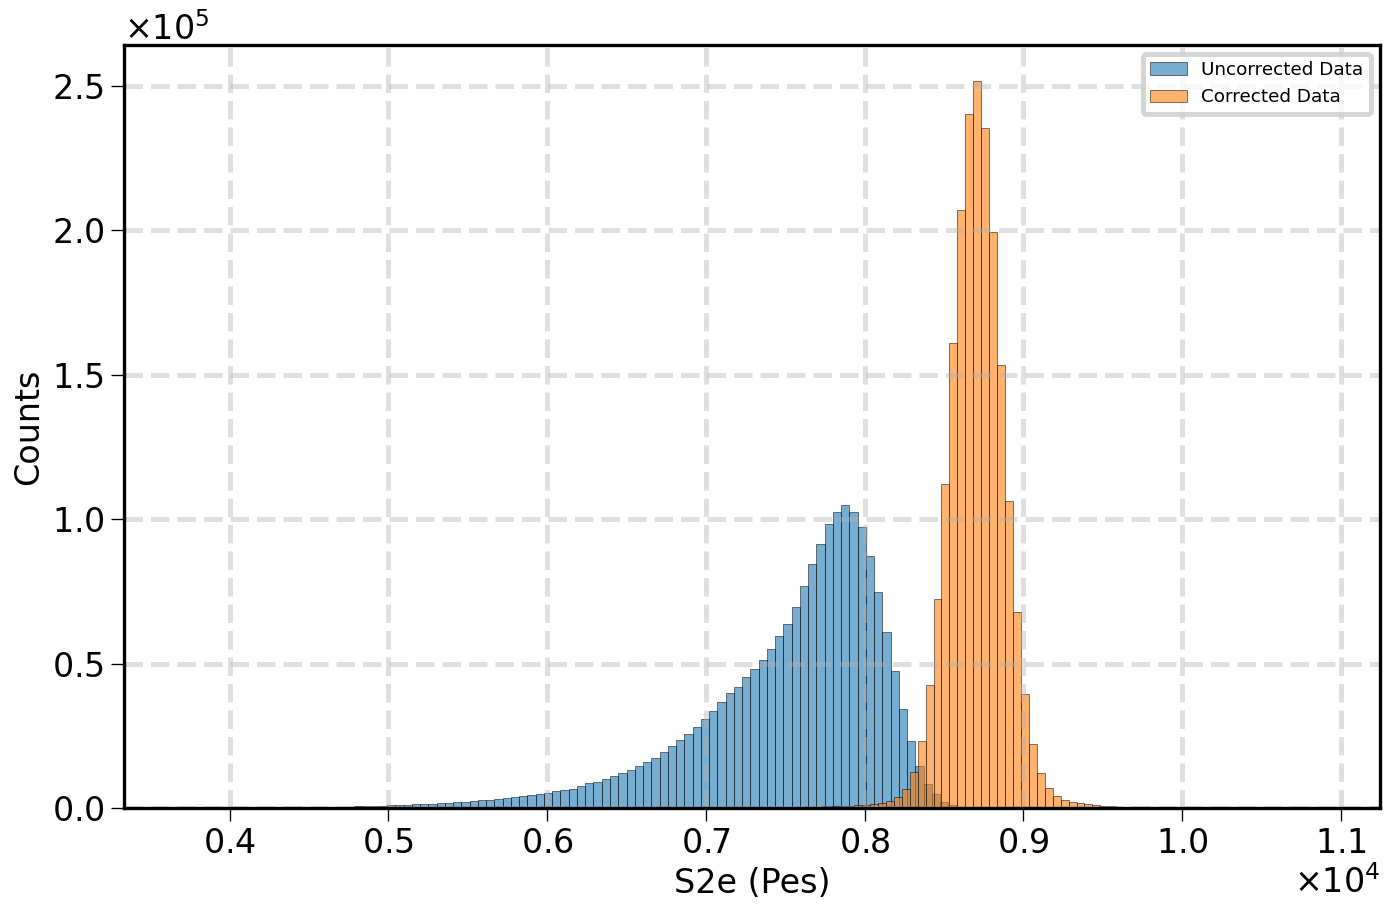

In [175]:
plt.figure(figsize=(12, 8), dpi=120)

# Plot S2e histogram
plt.hist(Krdf['S2e'], bins=100, alpha=0.6, color='tab:blue', edgecolor='black', linewidth=0.5, label='Uncorrected Data')

# Plot Epes histogram
plt.hist(Krdf['Epes'], bins=100, alpha=0.6, color='tab:orange', edgecolor='black', linewidth=0.5, label='Corrected Data')

# Aesthetic settings
plt.xlabel('S2e (Pes)')
plt.ylabel('Counts')
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

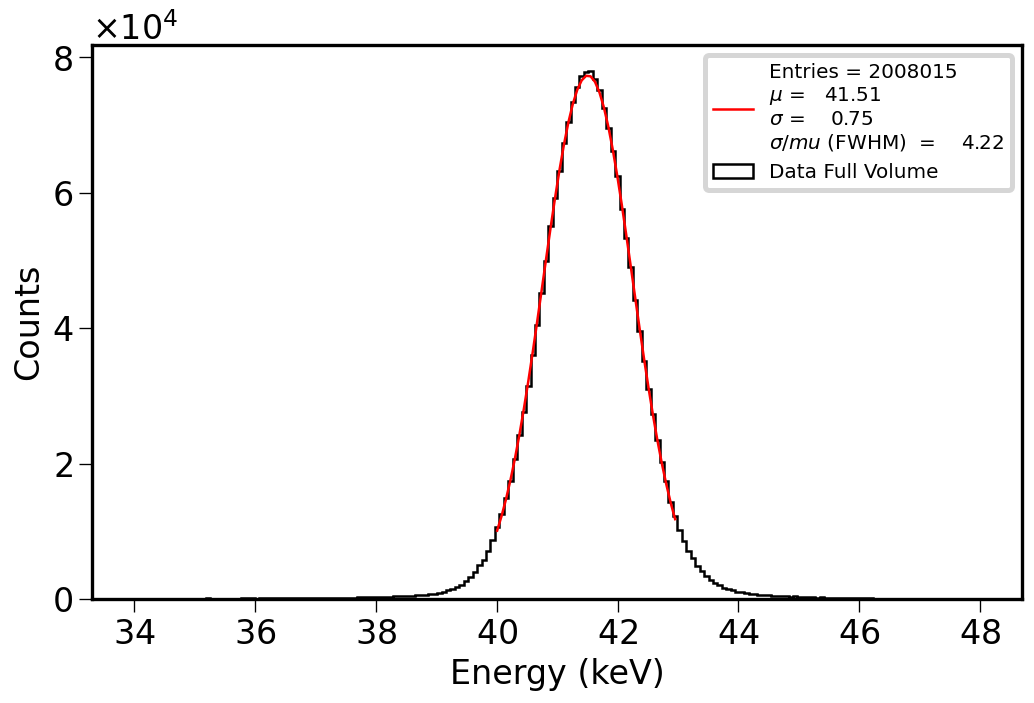

In [176]:
hp = af.HistoPar(var = Krdf['Epes']/Krdf['Epes'].mean()*41.5, nbins = 190, range = [34, 48])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 1.7)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data Full Volume")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

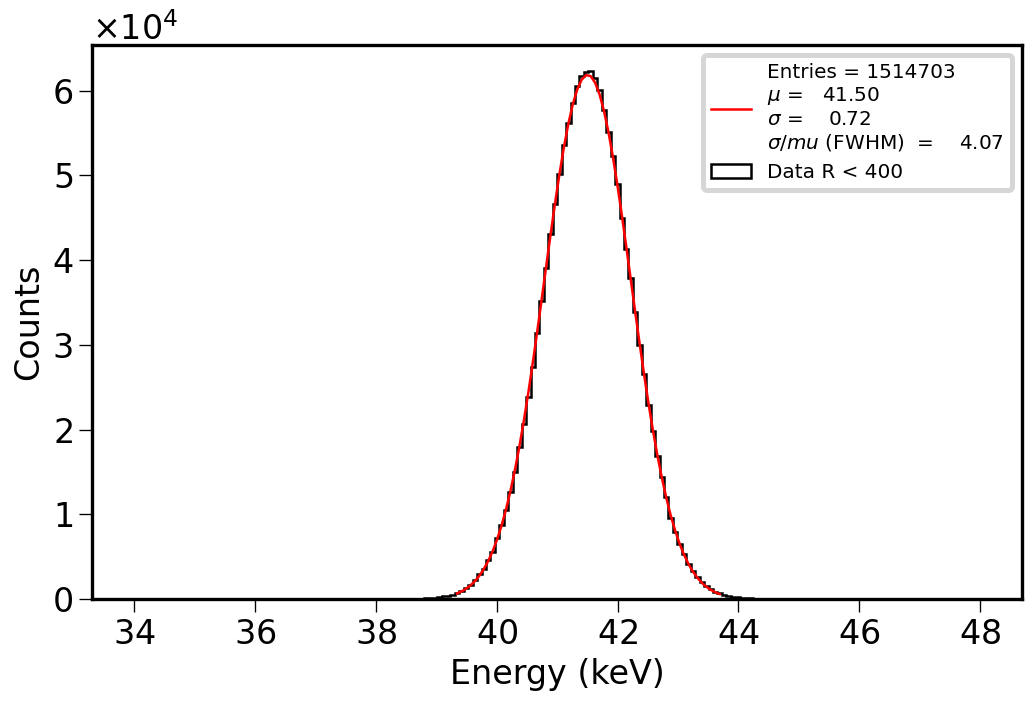

In [177]:
hp = af.HistoPar(var = Krdf[Krdf['R']<400]['Epes']/Krdf[Krdf['R']<400]['Epes'].mean()*41.5, nbins = 190, range = [34, 48])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 3)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data R < 400")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

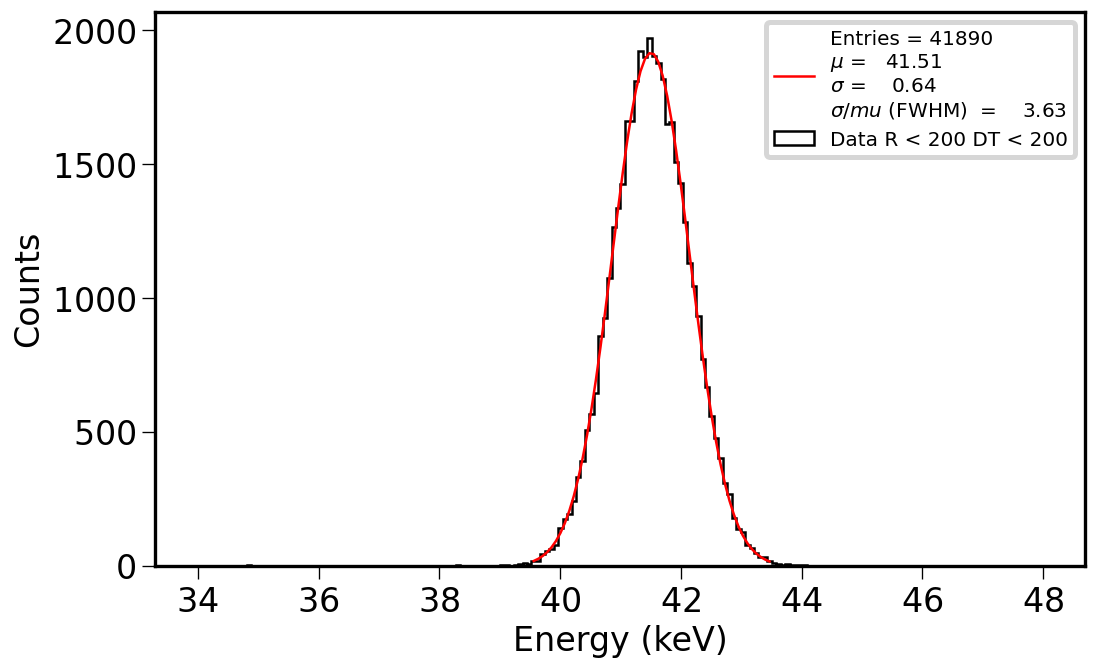

In [24]:
hp = af.HistoPar(var = Krdf[(Krdf['R']<200) & (Krdf['DT']<200)]['Epes']/Krdf[(Krdf['R']<200) & (Krdf['DT']<200)]['Epes'].mean()*41.5, nbins = 190, range = [34, 48])
fp, fr = af.fit_energy(hp.var, hp.nbins, hp.range, n_sigma  = 3)
fc = af.FitCollection(fp, hp, fr) 
plt.figure(figsize=(10, 6), dpi=120)
af.plot_fit_energy(fc,"Data R < 200 DT < 200")
plt.legend(fontsize=12)
plt.xlabel('Energy (keV)')
plt.ylabel('Counts')

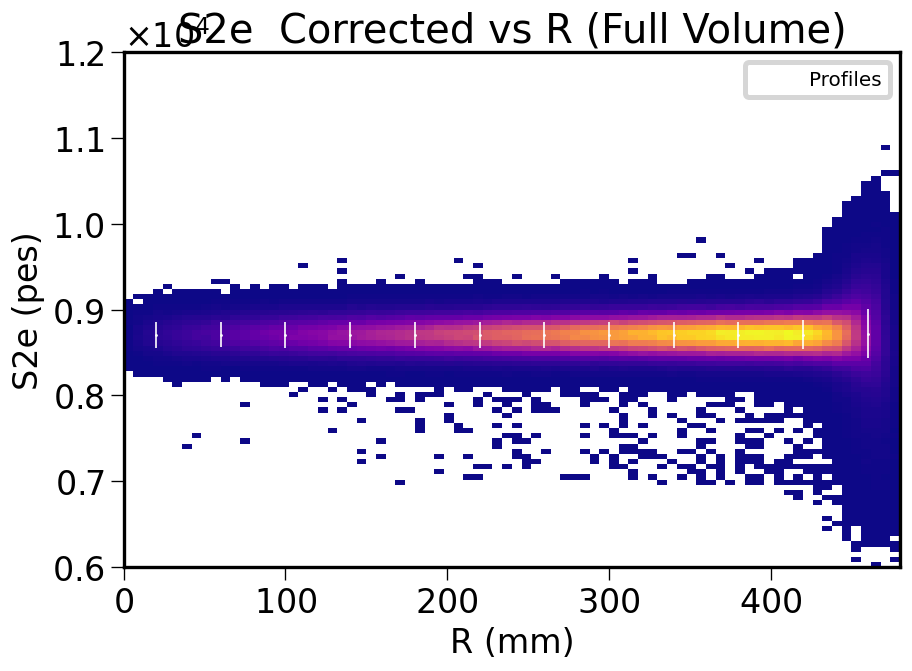

In [178]:
plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(Krdf['R'], Krdf['Epes'], bins=(80,100), range=([0, 480], [6000, 12000]))
r_centers, mean_vals_full_dt, mean_errs_full_dt, sigma_full_dt, sigma_errs_full_dt = af.gaussian_profiler_y_slices(counts2, xedges2, yedges2,12)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
plt.xlabel('R (mm)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')
plt.errorbar(r_centers, mean_vals_full_dt, yerr=sigma_full_dt, fmt='.', markersize=1.3, linewidth=1., color='w', label='Profiles')

plt.title('S2e  Corrected vs R (Full Volume)')
plt.legend(fontsize=12)
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

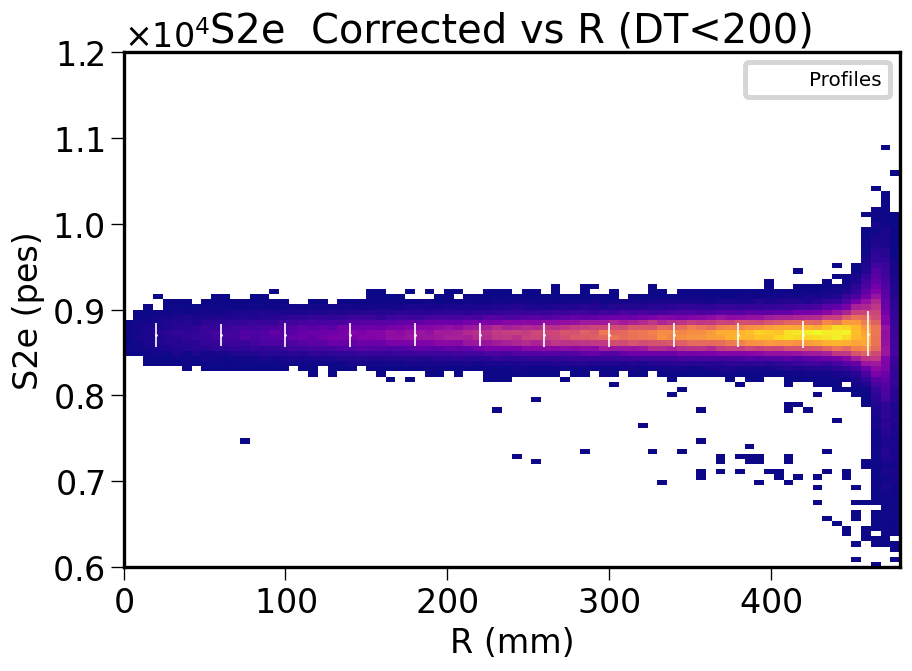

In [134]:
plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(Krdf[Krdf['DT']<200]['R'], Krdf[Krdf['DT']<200]['Epes'], bins=(80,100), range=([0, 480], [6000, 12000]))
r_centers, mean_vals_small_dt, mean_errs_small_dt, sigma_small_dt, sigma_errs_small_dt = af.gaussian_profiler_y_slices(counts2, xedges2, yedges2,12)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
plt.xlabel('R (mm)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')
plt.errorbar(r_centers, mean_vals_small_dt, yerr=sigma_small_dt, fmt='.', markersize=1.3, linewidth=1., color='w', label='Profiles')

plt.legend(fontsize=12)
plt.title('S2e  Corrected vs R (DT<200)')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

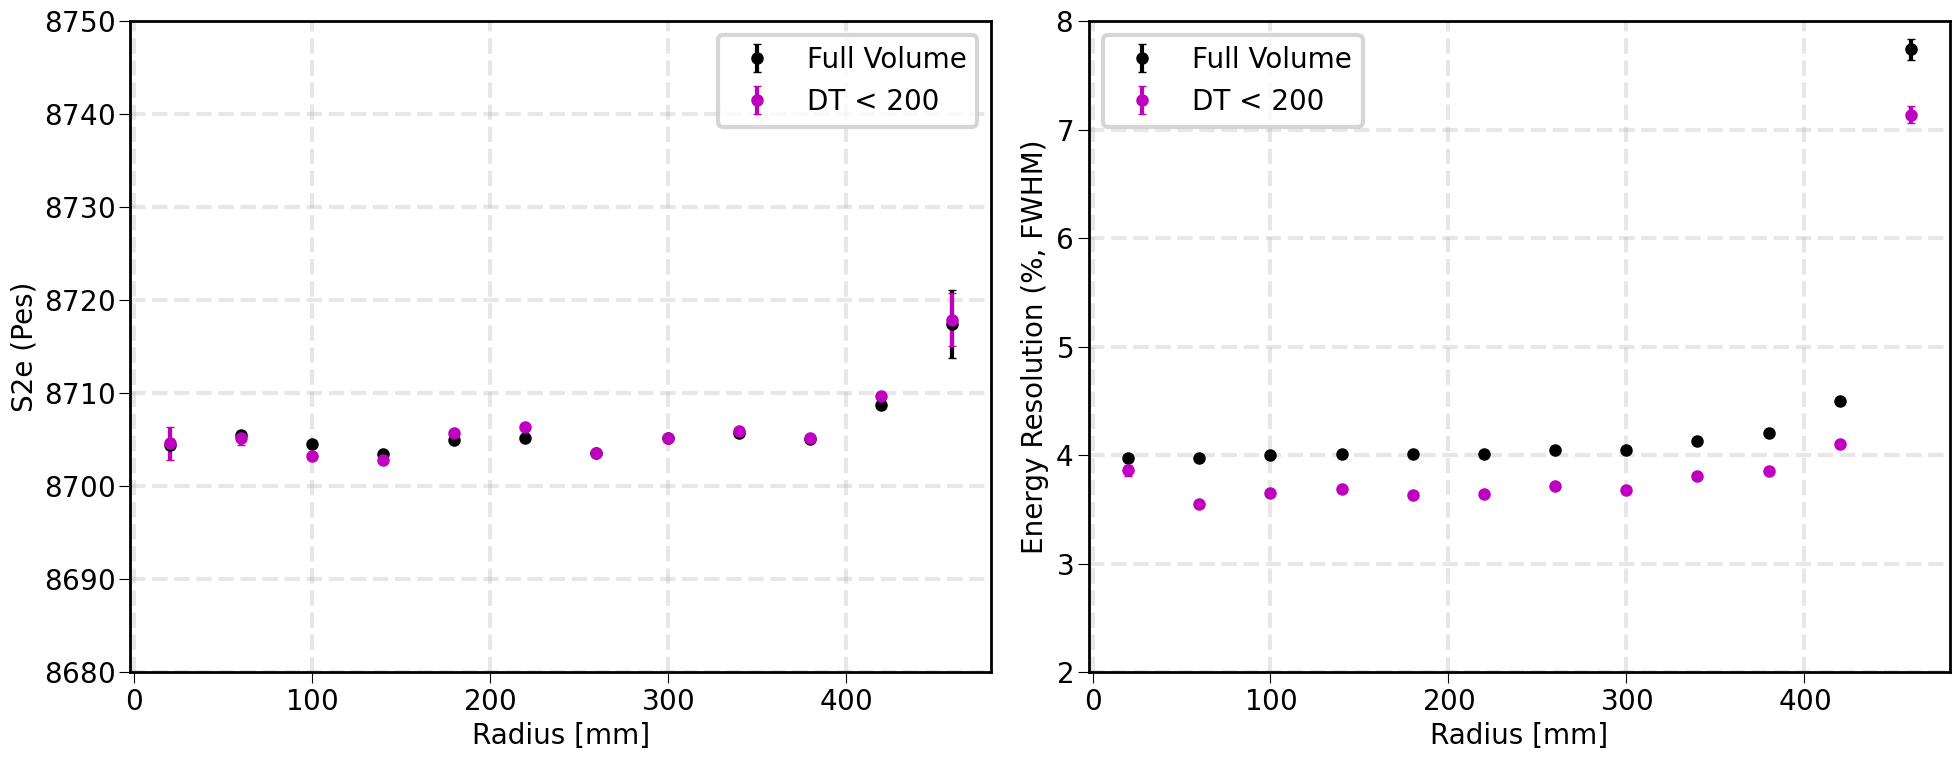

In [27]:
resolution_full, resolution_err_full = stats.compute_resolution_with_error(sigma_full_dt, sigma_errs_full_dt, mean_vals_full_dt, mean_errs_full_dt)
resolution_small, resolution_err_small = stats.compute_resolution_with_error(sigma_small_dt, sigma_errs_small_dt, mean_vals_small_dt, mean_errs_small_dt)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Mean vs. r_centers
ax1.errorbar(r_centers, mean_vals_full_dt, yerr=mean_errs_full_dt,
             fmt='o', capsize=3, markersize=8., label='Full Volume', color=color_sequence[0])
ax1.errorbar(r_centers, mean_vals_small_dt, yerr=mean_errs_small_dt,
             fmt='o', capsize=3, markersize=8., label='DT < 200', color=color_sequence[1])
ax1.set_xlabel('Radius [mm]')
ax1.set_ylabel('S2e (Pes)')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(8680,8750)
ax1.legend()

# Plot 2: Resolution vs. r_centers
ax2.errorbar(r_centers, resolution_full, yerr=resolution_err_full,
             fmt='o', capsize=3, markersize=8., color=color_sequence[0], label='Full Volume')
ax2.errorbar(r_centers, resolution_small, yerr=resolution_err_small,
             fmt='o', capsize=3, markersize=8., color=color_sequence[1], label='DT < 200')
ax2.set_xlabel('Radius [mm]')
ax2.set_ylabel('Energy Resolution (%, FWHM)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(2,8)
ax2.legend()

plt.tight_layout()
plt.show()

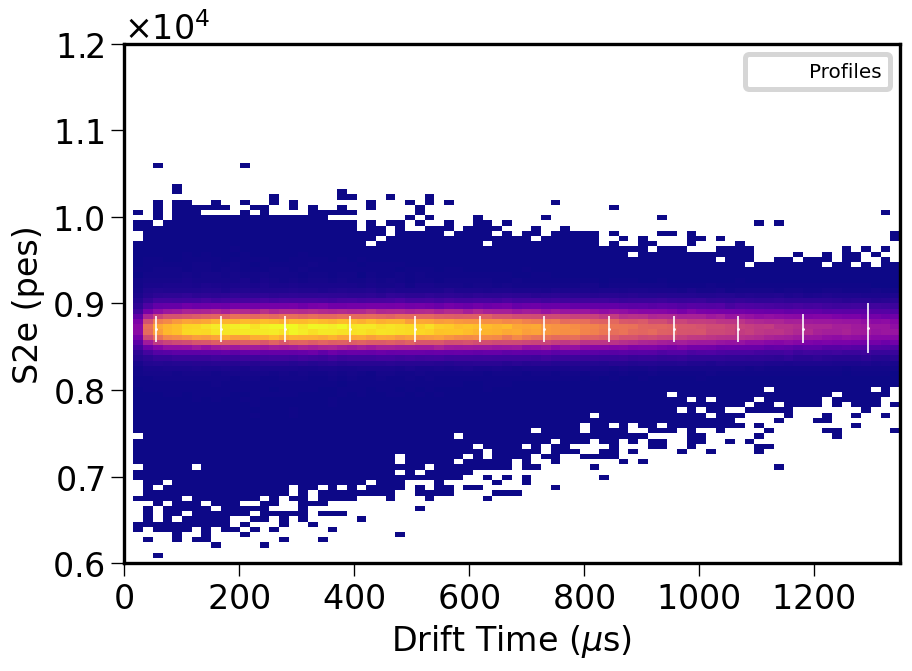

In [129]:
plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(Krdf[Krdf['R']<480]['DT'], Krdf[Krdf['R']<480]['Epes'], bins=(80,100), range=([0, 1350], [6000, 12000]))
dt_centers, mean_vals_full_r, mean_errs_full_r, sigma_full_r, sigma_errs_full_r = af.gaussian_profiler_y_slices(counts2, xedges2, yedges2,12)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')
plt.errorbar(dt_centers, mean_vals_full_dt, yerr=sigma_full_dt, fmt='.', markersize=1.3, linewidth=1., color='w', label='Profiles')

plt.legend(fontsize=12)
plt.title('S2e  Corrected vs DT (Full Volume)')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

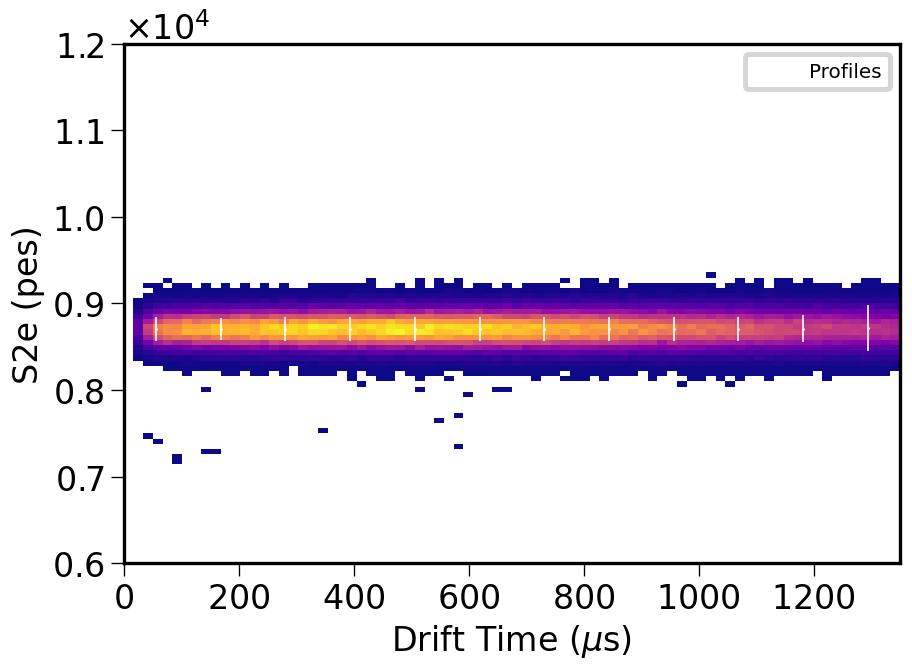

In [128]:
plt.figure(figsize=(8, 6), dpi=120)

counts2, xedges2, yedges2 = np.histogram2d(Krdf[Krdf['R']<200]['DT'], Krdf[Krdf['R']<200]['Epes'], bins=(80,100), range=([0, 1350], [6000, 12000]))
dt_centers, mean_vals_small_r, mean_errs_small_r, sigma_small_r, sigma_errs_small_r = af.gaussian_profiler_y_slices(counts2, xedges2, yedges2,12)

counts2[counts2 <= 1] = np.nan  # Mask bins with counts ≤ 1

plt.pcolormesh(xedges2, yedges2, counts2.T, cmap='plasma')
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel('S2e (pes)')
fig.colorbar(axes[1].collections[0], ax=axes[1], label='Counts')
plt.errorbar(dt_centers, mean_vals_small_dt, yerr=sigma_small_dt, fmt='.', markersize=1.3, linewidth=1., color='w', label='Profiles')

plt.legend(fontsize=12)
plt.title('S2e  Corrected vs DT (R<200)')
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

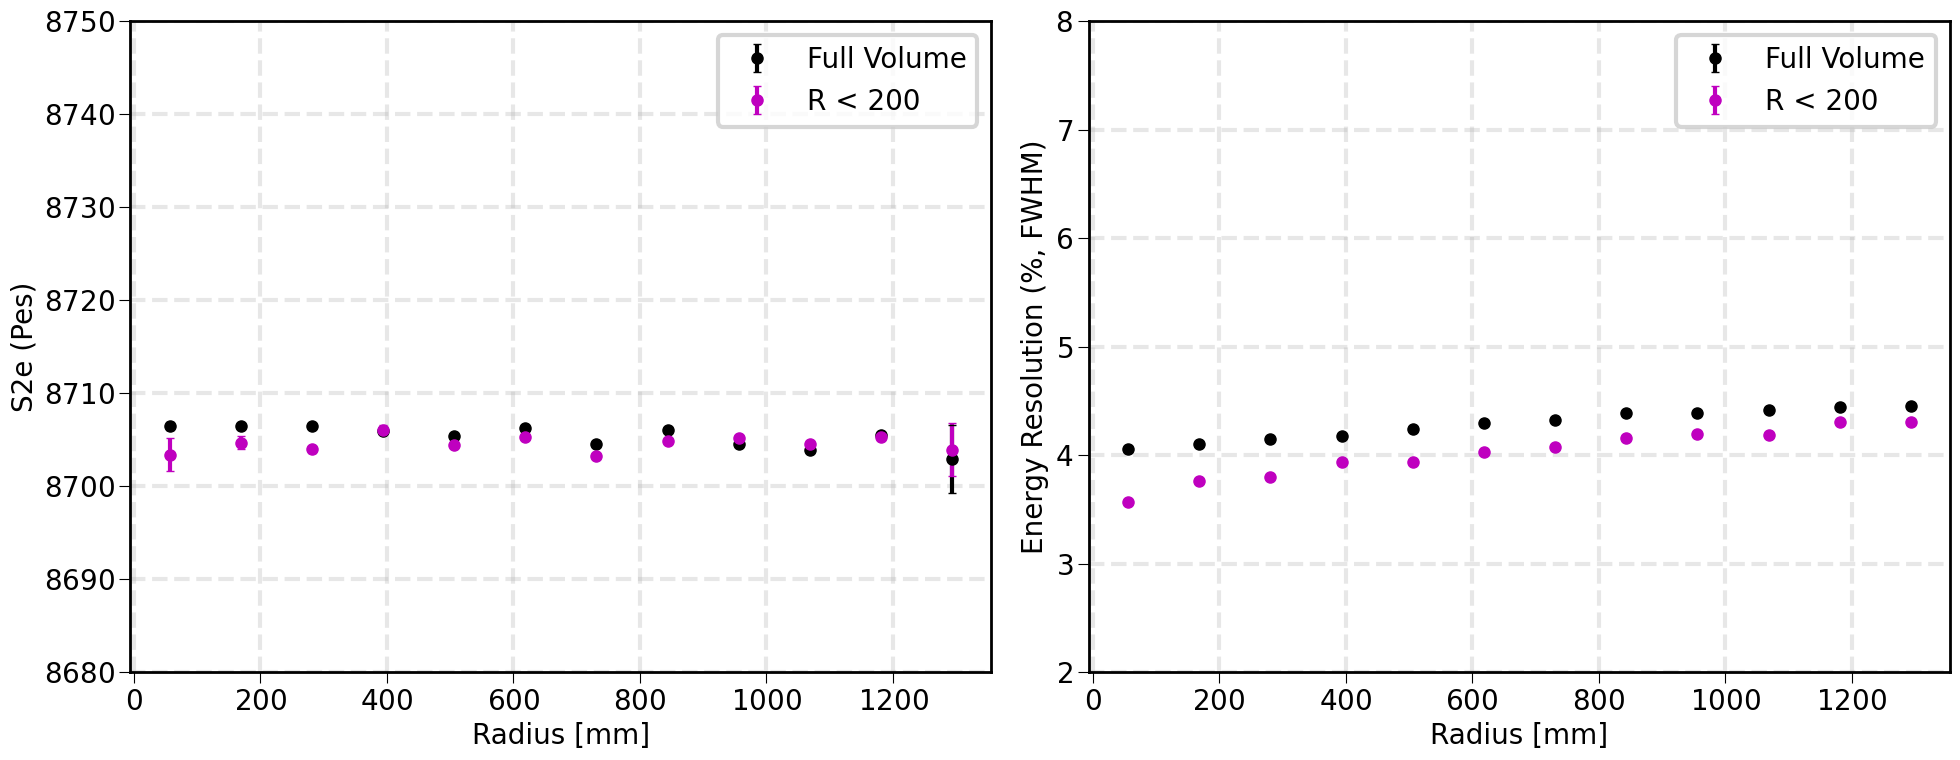

In [30]:
resolution_full, resolution_err_full = stats.compute_resolution_with_error(sigma_full_r, sigma_errs_full_r, mean_vals_full_r, mean_errs_full_r)
resolution_small, resolution_err_small = stats.compute_resolution_with_error(sigma_small_r, sigma_errs_small_r, mean_vals_small_r, mean_errs_small_r)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Mean vs. r_centers
ax1.errorbar(dt_centers, mean_vals_full_r, yerr=mean_errs_full_dt,
             fmt='o', capsize=3, markersize=8., label='Full Volume', color=color_sequence[0])
ax1.errorbar(dt_centers, mean_vals_small_r, yerr=mean_errs_small_dt,
             fmt='o', capsize=3, markersize=8., label='R < 200', color=color_sequence[1])
ax1.set_xlabel('Radius [mm]')
ax1.set_ylabel('S2e (Pes)')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(8680,8750)
ax1.legend()

# Plot 2: Resolution vs. r_centers
ax2.errorbar(dt_centers, resolution_full, yerr=resolution_err_full,
             fmt='o', capsize=3, markersize=8., color=color_sequence[0], label='Full Volume')
ax2.errorbar(dt_centers, resolution_small, yerr=resolution_err_small,
             fmt='o', capsize=3, markersize=8., color=color_sequence[1], label='R < 200')
ax2.set_xlabel('Radius [mm]')
ax2.set_ylabel('Energy Resolution (%, FWHM)')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(2,8)
ax2.legend()

plt.tight_layout()
plt.show()

### DT Resolution Noise Correction

In [31]:
df_resonoise = pd.read_hdf("../db/NoiseResoEffect.h5")

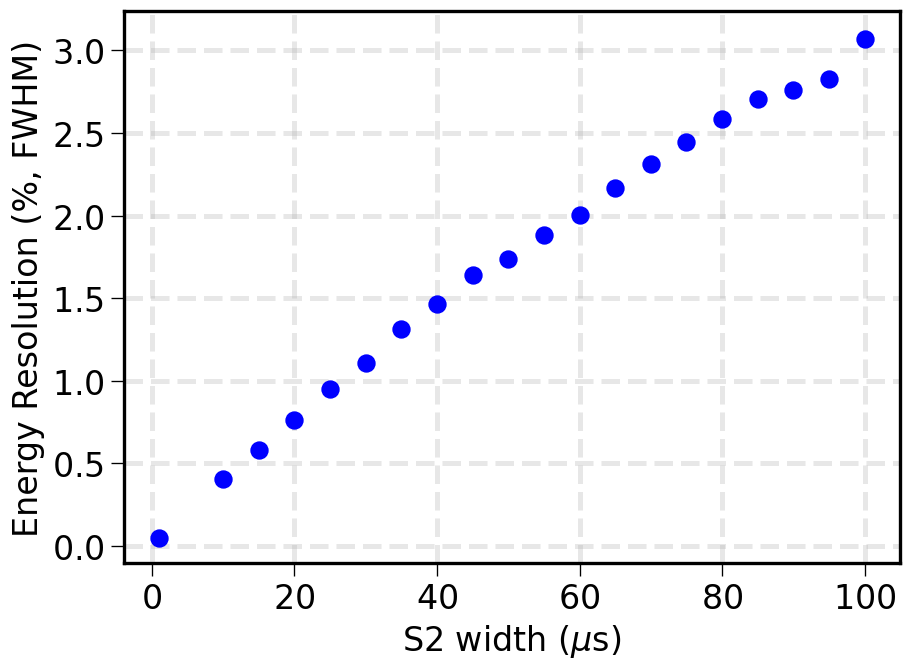

In [32]:
# Constants
E0 = Krdf['Epes'].mean()

# Compute y values and errors
y = 235 * df_resonoise["sig"] / E0
yerr = 235 * df_resonoise["usig"] / E0
x = df_resonoise["sz"]

# Plot
plt.figure(figsize=(8, 6), dpi=120)

plt.errorbar(x, y, yerr=yerr, fmt='o', markersize=10.,capsize=3, color='b')
plt.xlabel('S2 width ($\mu$s)')
plt.ylabel(r'Energy Resolution (%, FWHM)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

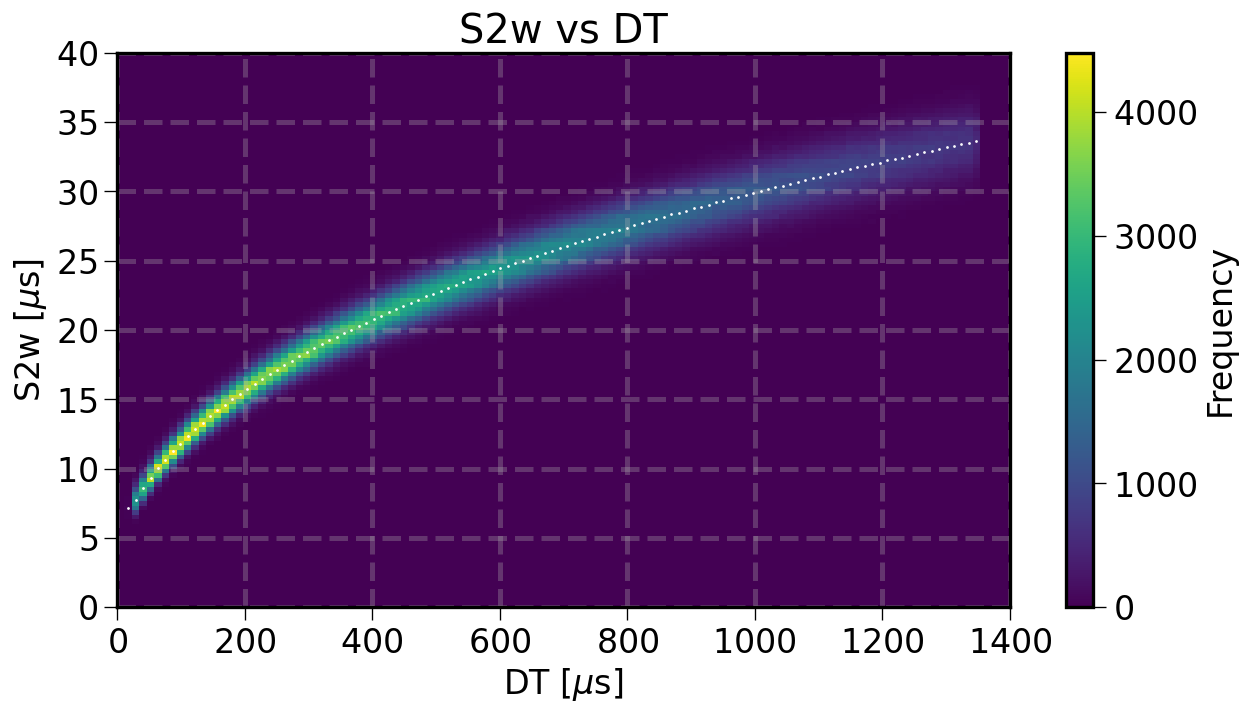

In [33]:
plt.figure(figsize=(12, 6), dpi=120)
hist, xedges, yedges, im = plt.hist2d(Krdf['DT'], Krdf['S2w'],
                                      bins=(120, 120),
                                      range=([0, 1400], [0, 40]),
                                      cmap='viridis')

results = af.gaussian_profiler_y(hist, xedges, yedges)
xdata = results[0]
ydata = results[1]

plt.errorbar(xdata, ydata, yerr=None, fmt='.', markersize=1.3, linewidth=1., color='w', label='Gauss Fit results')

plt.colorbar(label='Frequency')
plt.xlabel('DT [$\mu$s]')
plt.ylabel('S2w [$\mu$s]')
plt.title('S2w vs DT')
plt.grid(True, alpha=0.3)

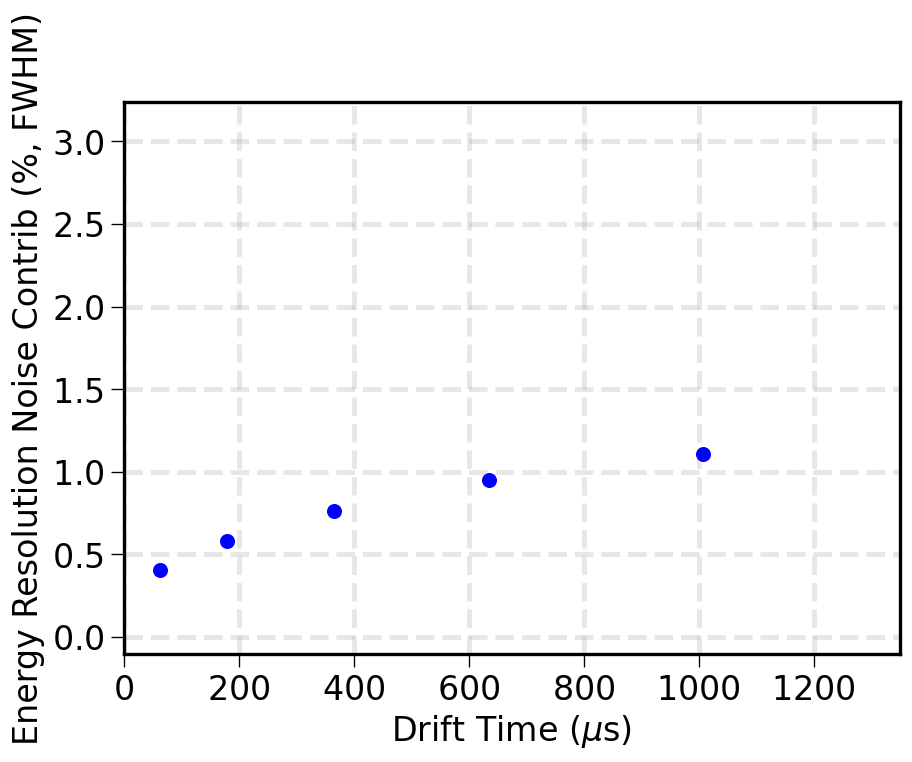

In [34]:
plt.figure(figsize=(8, 6), dpi=120)

# Create interpolation function: DT as a function of S2w
interp_func = interp1d(ydata, xdata, kind='quadratic', bounds_error=False, fill_value='extrapolate')

# Now transform x (S2w values) to DT values
x_transformed = interp_func(x)  # These are now DT values

plt.errorbar(x_transformed, y, yerr=yerr, fmt='o', markersize=8., capsize=3, color='b')
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel(r'Energy Resolution Noise Contrib (%, FWHM)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(0,1350)
plt.show()

In [35]:
# Create the interpolation function from EReso vs DT
interp_func = interp1d(x_transformed, y, kind='quadratic', bounds_error=False, fill_value='extrapolate')

# Interpolate at slice_centers of the EReso vs Dt Plot
y_interp = interp_func(dt_centers)

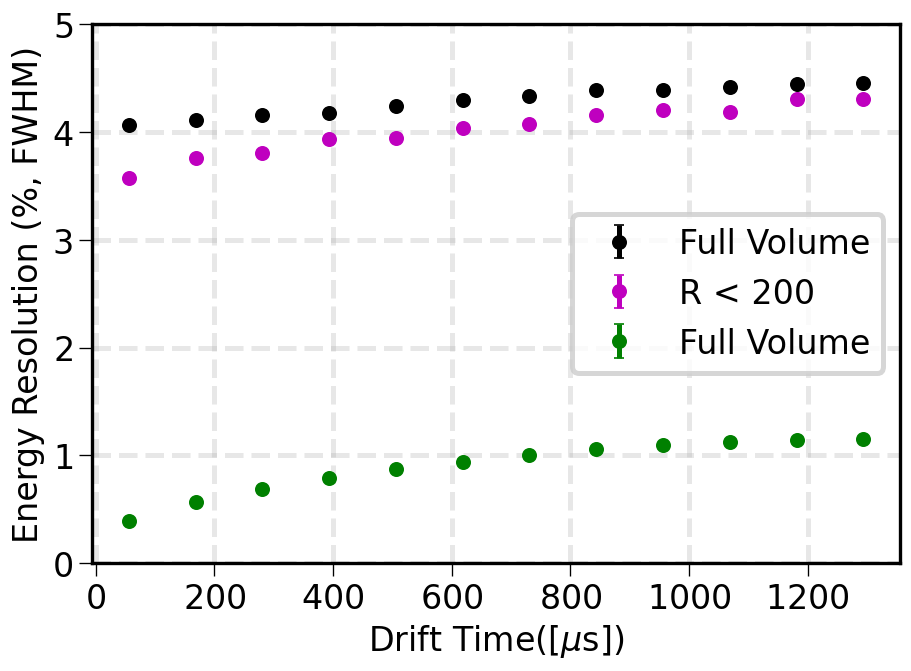

In [36]:
# Plot Full Volume
plt.figure(figsize=(8, 6), dpi=120)

# Plot 2: Resolution vs. r_centers
plt.errorbar(dt_centers, resolution_full, yerr=resolution_err_full,
             fmt='o', capsize=3, markersize=8., color=color_sequence[0], label='Full Volume')
plt.errorbar(dt_centers, resolution_small, yerr=resolution_err_small,
             fmt='o', capsize=3, markersize=8., color=color_sequence[1], label='R < 200')

# Plot interpolated values (assumed to be y_interp vs slice_centers)
plt.errorbar(dt_centers,y_interp, yerr=0,
    fmt='o', capsize=3, markersize=8., color=color_sequence[2], label='Full Volume')


# Labels, legend, etc.
plt.xlabel('Drift Time([$\mu$s])')
plt.ylabel('Energy Resolution (%, FWHM)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0,5)
plt.tight_layout()
plt.show()

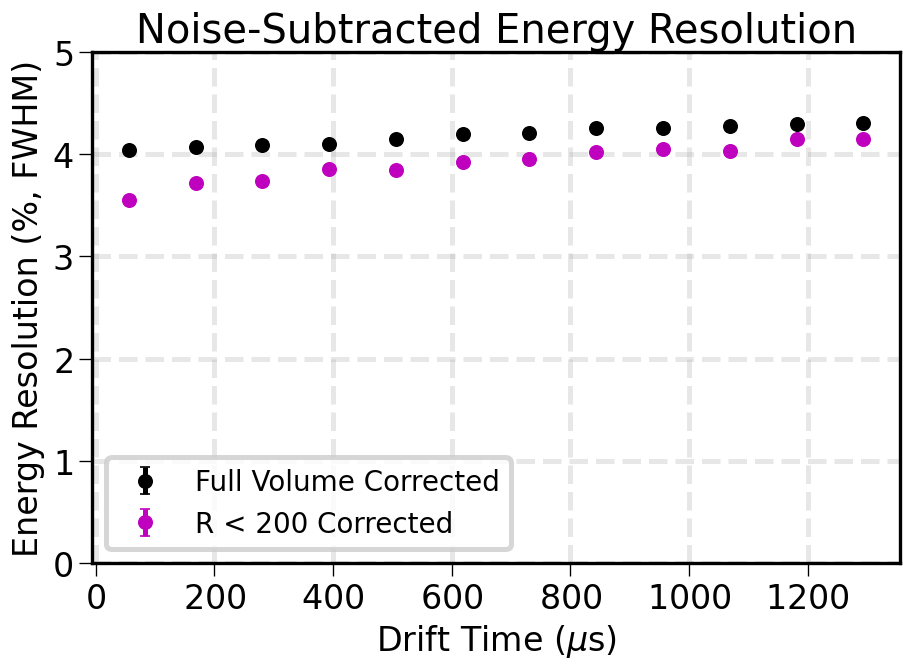

In [37]:
plt.figure(figsize=(8, 6), dpi=120)

# Full Volume: sqrt(mean² - y_interp²)
res_full = np.sqrt(np.square(resolution_full) - np.square(y_interp))
plt.errorbar(
    dt_centers,
    res_full,
    yerr=resolution_err_full,
    fmt='o', capsize=3, markersize=8.,
    color='k',
    label='Full Volume Corrected'
)

# Small R: sqrt(mean² - y_interp²)
res_smallR = np.sqrt(np.square(resolution_small) - np.square(y_interp))
plt.errorbar(
    dt_centers,
    res_smallR,
    yerr=resolution_err_small,
    fmt='o', capsize=3, markersize=8.,
    color='m',
    label='R < 200 Corrected'
)

# Final touches
plt.xlabel('Drift Time ($\mu$s)')
plt.ylabel('Energy Resolution (%, FWHM)')
plt.title('Noise-Subtracted Energy Resolution')
plt.grid(True, alpha=0.3)
plt.ylim(0,5)
plt.legend(fontsize='small')
plt.tight_layout()
plt.show()

### Radial response analysis in angular sectors 

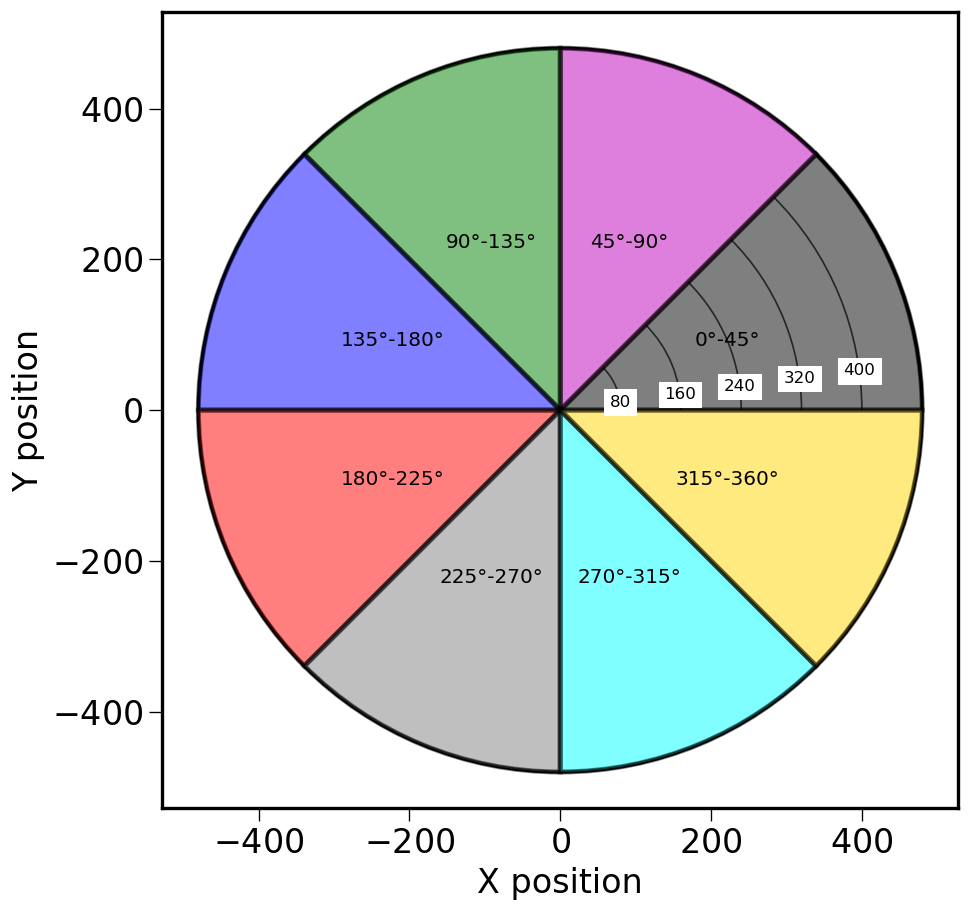

In [125]:
sector_angle = 45 #Degrees
radial_bins_per_sector= 6 #Radial sectors along R

pf.plot_circular_sectors(sector_angle, radial_bins_per_sector, dpi=120)

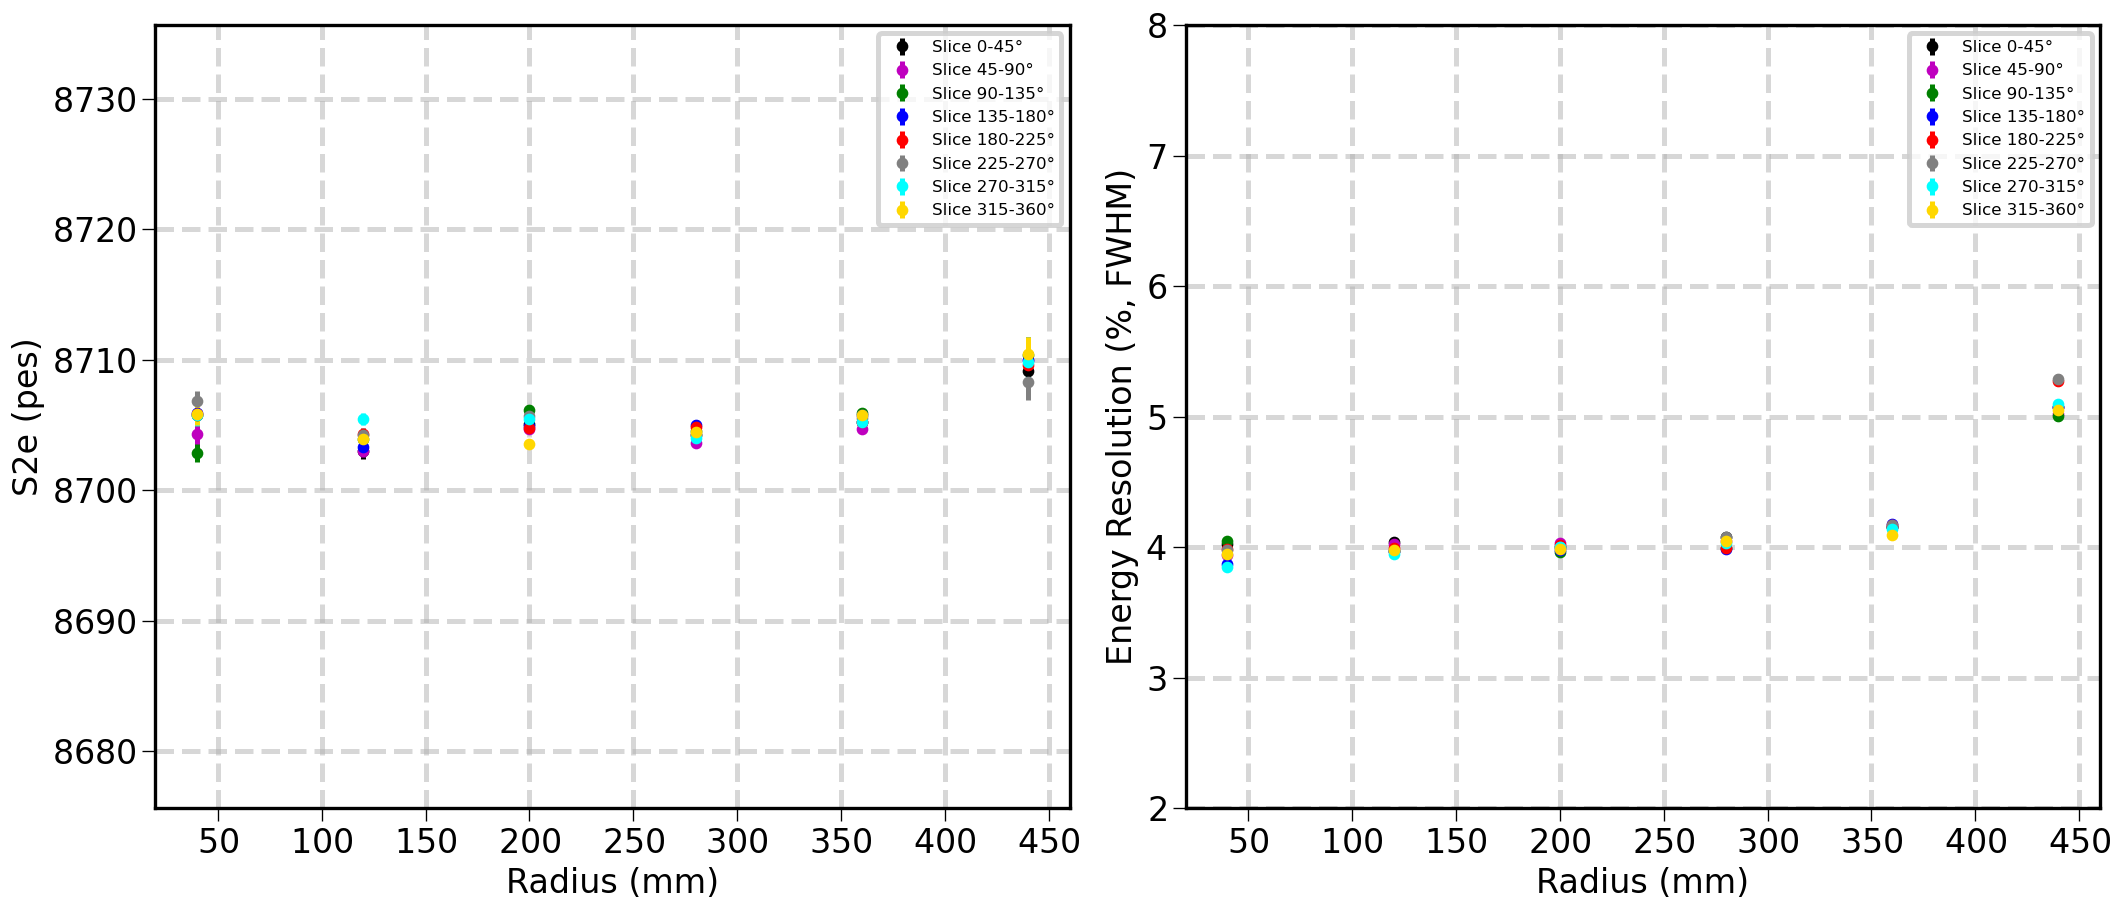

In [127]:
results, r_centers = af.response_in_sector(Krdf, sector_angle, radial_bins_per_sector)
af.plot_response_vs_radius_insector(r_centers, results, sector_angle, stats.compute_resolution_with_error, color_sequence)

### Lifetime

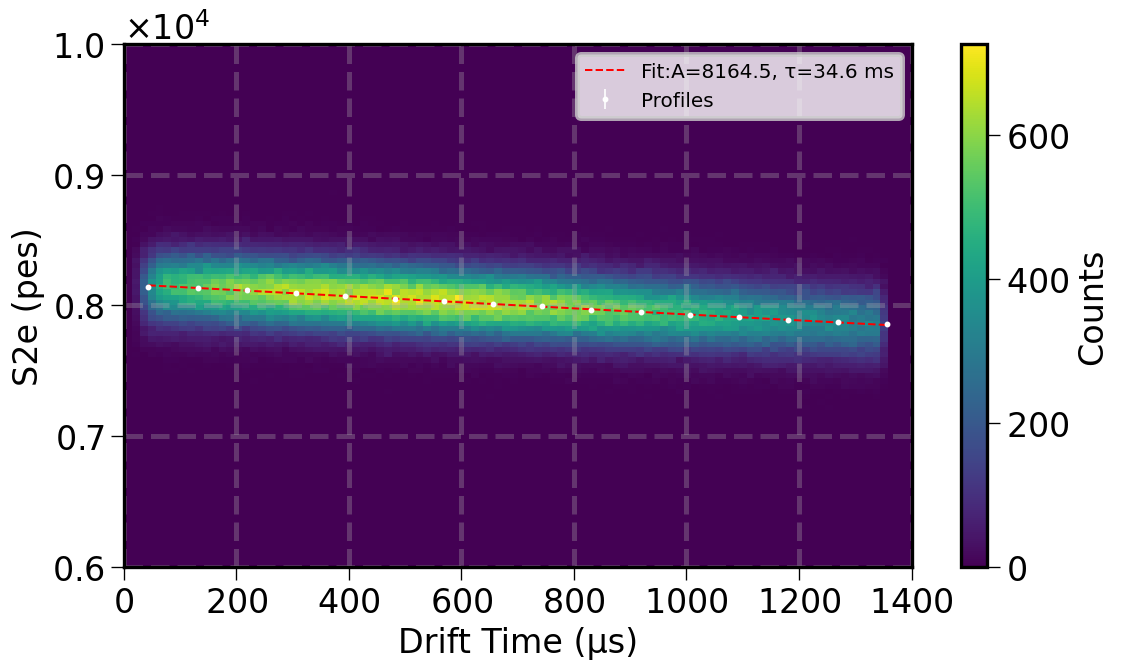

In [159]:
# Define exponential function for the fit
def exp_decay(t, A, tau):
    return A * np.exp(-t / tau)

# Compute 2D histogram
counts, xedges, yedges = np.histogram2d(
    Krdf[Krdf['R'] < 250]["DT"], Krdf[Krdf['R'] < 250]["S2e"],
    bins=(100, 100),
    range=((0, 1400), (6000, 10000))
)

# Recompute profiles for plotting
dt_centers, mean_vals, mean_errs, sigma, sigma_errs = af.gaussian_profiler_y_slices(counts, xedges, yedges, 16)

# Fit the exponential to the mean values
popt, pcov = curve_fit(exp_decay, dt_centers, mean_vals, p0=[8000,30000], sigma=mean_errs, absolute_sigma=True)
A_fit, tau_fit = popt

# Evaluate fit
t_fit = np.linspace(dt_centers.min(), dt_centers.max(), 300)
y_fit = exp_decay(t_fit, *popt)

# Plot
plt.figure(figsize=(10, 6), dpi=120)
plt.imshow(
    counts.T,
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)
plt.errorbar(dt_centers, mean_vals, yerr=mean_errs, fmt='.', markersize=5, linewidth=1., color='w', label='Profiles')
plt.plot(t_fit, y_fit, 'r--', linewidth =1.2, label=f'Fit:A={A_fit:.1f}, τ={tau_fit/1000:.1f} ms')

plt.colorbar(label='Counts')
plt.xlabel('Drift Time (µs)')
plt.ylabel('S2e (pes)')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()